In [1]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures

#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Raw Data

In [38]:
#Set dataset

datasetDirectory = ""

In [7]:
#Import raw JIRA dataset
rawData_JIRA_MxShop = pd.read_excel('../data/01_raw/JIRA Mendix Engagement export_22_06_2021.xlsx')

#import
rawData_SVN_MxShop = loadCommits('../data/01_raw/MxShop-dump.txt')

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [4]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+|AFI+.[0-9]+|EM+.[0-9]+|OE+.[0-9]+|EM+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noInterpunction)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(tokensWithoutSW)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [5]:
#Start timer
startTime = time.time() 

intermediateData_SVN_MxShop = cleanCommitData(rawData_SVN_MxShop)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_MxShop.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_MxShop.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_MxShop.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_MxShop.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 1.6439402103424072 seconds


In [6]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rande\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
#Rename key to Issue key
rawData_JIRA_MxShop = rawData_JIRA_MxShop.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_MxShop = cleanJiraData(dataFrame = rawData_JIRA_MxShop, cleanComments = False, commentAmount = 39)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_MxShop.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_MxShop.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_MxShop.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_MxShop.pkl")

1/3) Finished Cleaning Summaries after 0.3699226379394531 sec
2/3) Finished Cleaning Description after 2.9697020053863525 sec
3/3) Finished Cleaning Dates after 2.9697020053863525 sec


## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA UNIGRAM

In [8]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [9]:
#Create JIRA corpus for MxShop dataset
intermediateData_JIRA_MxShopCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_MxShop.Summary)
intermediateData_JIRA_MxShopCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_MxShop.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_MxShopCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_MxShopCorpusSummary,
                                                                             intermediateData_JIRA_MxShopCorpusDescription
                                                                            )]

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_MxShopCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_MxShopCorpus, f)

Bigram corpora

In [10]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [11]:
#Create JIRA corpus for MxShop dataset
intermediateData_JIRA_MxShopCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_MxShop.Summary_2grams)
intermediateData_JIRA_MxShopCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_MxShop.Description_2grams)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_MxShopCorpus_2gram = [i+" "+j for i,j in zip(intermediateData_JIRA_MxShopCorpusSummary_2grams,
                                                                             intermediateData_JIRA_MxShopCorpusDescription_2grams
                                                                             )]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_MxShopCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_MxShopCorpus_2gram, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [12]:
intermediateData_SVN_MxShop = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_MxShop.pkl")

In [13]:
#Create corpus for log messages
intermediateData_SVNLogs_MxShopCorpus = createCorpusFromDocumentList(intermediateData_SVN_MxShop.Logs)

#Create corpus for unit names
intermediateData_SVNUnitNames_MxShopCorpus = createCorpusFromDocumentList(intermediateData_SVN_MxShop.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_MxShopCorpus = createCorpusFromDocumentList(intermediateData_SVN_MxShop.Logs + intermediateData_SVN_MxShop.Unit_names)
intermediateData_SVN_MxShopCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_MxShop.Logs + intermediateData_SVN_MxShop.Unit_names)
#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVNLogs_MxShopCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_MxShopCorpus, f)

with open('../data/02_intermediate/intermediateData_SVNUnitNames_MxShopCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_MxShopCorpus, f)

with open('../data/02_intermediate/intermediateData_SVN_MxShopCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_MxShopCorpus, f)
    
with open('../data/02_intermediate/intermediateData_SVN_MxShopCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_MxShopCorpusAll, f)

bigram corpora

In [14]:
intermediateData_SVNLogs_MxShopCorpus_2gram = createCorpusNGrams(intermediateData_SVN_MxShop.Logs_2grams)
intermediateData_SVNUnitNames_MxShopCorpus_2gram = createCorpusNGrams(intermediateData_SVN_MxShop.Unit_names_2grams)
with open('../data/02_intermediate/intermediateData_SVNLogs_MxShopCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_MxShopCorpus_2gram, f)
    
    
with open('../data/02_intermediate/intermediateData_SVNUnitNames_MxShopCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_MxShopCorpus_2gram, f)

# 3. Preprocess Data

In [15]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_MxShop = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_MxShop.pkl")

intermediateData_SVN_MxShop = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_MxShop.pkl")

intermediateData_JIRA_MxShopCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_MxShopCorpus.pkl')
intermediateData_JIRA_MxShopCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_MxShopCorpus.pkl')
#intermediateData_SVN_MxShopCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_MxShopCorpusAll.pkl')
#intermediateData_SVN_MxShopCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_MxShopCorpusModel.pkl')
intermediateData_SVN_MxShopCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_MxShopCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [16]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

#Create cartesian products JIRA x Commits
processedData_MxShopCartesian = intermediateData_JIRA_MxShop.merge(intermediateData_SVN_MxShop, how='cross')
processedData_MxShopCartesian.info()
processedData_MxShopCartesian = processedData_MxShopCartesian.drop(processedData_MxShopCartesian[processedData_MxShopCartesian.Jira_created_date > processedData_MxShopCartesian.Commit_date].index)

#Create a pickle file for all intermediate datasets
processedData_MxShopCartesian.to_pickle(path= "../data/03_processed/processedData_MxShopCartesian.pkl")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129970 entries, 0 to 129969
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Issue_key_jira              129970 non-null  object        
 1   Assignee                    62935 non-null   object        
 2   Jira_created_date           129970 non-null  datetime64[ns]
 3   Jira_updated_date           129970 non-null  datetime64[ns]
 4   Jira_resolved_date          85690 non-null   datetime64[ns]
 5   Summary                     129970 non-null  object        
 6   Summary_2grams              129970 non-null  object        
 7   Summary_3grams              129970 non-null  object        
 8   Description                 129970 non-null  object        
 9   Description_2grams          129970 non-null  object        
 10  Description_3grams          129970 non-null  object        
 11  Jira_natural_text           129970 non-

In [17]:
processedData_MxShopCartesian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33627 entries, 1432 to 129969
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Issue_key_jira              33627 non-null  object        
 1   Assignee                    15017 non-null  object        
 2   Jira_created_date           33627 non-null  datetime64[ns]
 3   Jira_updated_date           33627 non-null  datetime64[ns]
 4   Jira_resolved_date          20409 non-null  datetime64[ns]
 5   Summary                     33627 non-null  object        
 6   Summary_2grams              33627 non-null  object        
 7   Summary_3grams              33627 non-null  object        
 8   Description                 33627 non-null  object        
 9   Description_2grams          33627 non-null  object        
 10  Description_3grams          33627 non-null  object        
 11  Jira_natural_text           33627 non-null  object

## 3.1 Preprocess Data - Create Labels

In [18]:
#Create new dataFrames for the time features
processedData_MxShopLabels = pd.DataFrame() 


#Create a column, which indicates which traces are valid.
processedData_MxShopLabels["is_valid"] = processedData_MxShopCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for MxShop")

#Save intermediate results
processedData_MxShopLabels.to_pickle(path= "../data/03_processed/processedData_MxShopLabels.pkl")

processedData_MxShopLabels.info()

Finished creating labels for MxShop
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33627 entries, 1432 to 129969
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_valid  33627 non-null  bool 
dtypes: bool(1)
memory usage: 295.5 KB


In [19]:
#processedData_MxShopLabels[processedData_MxShopLabels.is_valid == True].count()
processedData_MxShopLabels[processedData_MxShopLabels.is_valid == True].count()

is_valid    86
dtype: int64

## 3.2 Preprocess Data - Create Time-Related Features

In [20]:
#Create new dataFrames for the time features
processedData_MxShopFeaturesTime = pd.DataFrame() 


#Calculate the time features for data Processing Dataset
processedData_MxShopFeaturesTime['Creation_commit_date_dif'] = processedData_MxShopCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_MxShopFeaturesTime['Updated_commit_date_dif'] = processedData_MxShopCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_MxShopFeaturesTime['Resolved_commit_date_dif'] = processedData_MxShopCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")

#Create a pickle file for all intermediate datasets
processedData_MxShopFeaturesTime.to_pickle(path= "../data/03_processed/processedData_MxShopFeaturesTime.pkl")

Finished data Processing


## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [21]:
#Create new dataFrames for the Stakeholder features
processedData_MxShopFeaturesStakeholder = pd.DataFrame() 

processedData_MxShopFeaturesStakeholder['Assignee_is_commiter'] = processedData_MxShopCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished MxShop")

#Create a pickle file for all intermediate datasets
processedData_MxShopFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_MxShopFeaturesStakeholder.pkl")


Finished MxShop


In [22]:
processedData_MxShopFeaturesStakeholder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33627 entries, 1432 to 129969
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Assignee_is_commiter  15017 non-null  float64
dtypes: float64(1)
memory usage: 525.4 KB


## 3.4 Preprocess Data - Create Cosine Similarity Features
### 3.4.1 MxShop - Cosine Similarity UniGrams

In [23]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)

def calculateCosineSimilarityNGrams(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

In [24]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       MxShop              #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVN_MxShopCountVectorizer = CountVectorizer()
processedData_SVN_MxShopCountTF_IDF = createFittedTF_IDF(processedData_SVN_MxShopCountVectorizer, intermediateData_SVN_MxShopCorpus)

processedData_SVNLogs_MxShopCountVectorizer = CountVectorizer()
processedData_SVNLogs_MxShopCountTF_IDF = createFittedTF_IDF(processedData_SVNLogs_MxShopCountVectorizer, intermediateData_SVNLogs_MxShopCorpus)

processedData_SVNUnitNames_MxShopCountVectorizer = CountVectorizer()
processedData_SVNUnitNames_MxShopCountTF_IDF = createFittedTF_IDF(processedData_SVNUnitNames_MxShopCountVectorizer, intermediateData_SVNUnitNames_MxShopCorpus)

#instantiate CountVectorizer() for JIRA - unigram
processedData_JIRA_MxShopCountVectorizer = CountVectorizer()
processedData_JIRA_MxShopCountTF_IDF = createFittedTF_IDF(processedData_JIRA_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpus)

processedData_JIRASummaries_MxShopCountVectorizer = CountVectorizer()
processedData_JIRASummaries_MxShopCountTF_IDF = createFittedTF_IDF(processedData_JIRASummaries_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpusSummary)

processedData_JIRADescriptions_MxShopCountVectorizer = CountVectorizer()
processedData_JIRADescriptions_MxShopCountTF_IDF = createFittedTF_IDF(processedData_JIRADescriptions_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpusDescription)

#processedData_JIRAComments_MxShopCountVectorizer = CountVectorizer()
#processedData_JIRAComments_MxShopCountTF_IDF = createFittedTF_IDF(processedData_JIRAComments_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpusComments)


################# Bigrams ###############
#instantiate CountVectorizer() for SVN - bigrams
processedData_SVNLogs_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_SVNLogs_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNLogs_MxShopCountVectorizer_2gram, intermediateData_SVNLogs_MxShopCorpus_2gram)

processedData_SVNUnitNames_MxShopCountVectorizer_2gram = CountVectorizer()
processedData_SVNUnitNames_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNUnitNames_MxShopCountVectorizer_2gram, intermediateData_SVNUnitNames_MxShopCorpus_2gram)


#instantiate CountVectorizer() for JIRA - biigram
processedData_JIRA_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRA_MxShopCountVectorizer_2gram, intermediateData_JIRA_MxShopCorpus_2gram)

processedData_JIRASummaries_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRASummaries_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRASummaries_MxShopCountVectorizer_2gram, intermediateData_JIRA_MxShopCorpusSummary_2grams)

processedData_JIRADescriptions_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRADescriptions_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRADescriptions_MxShopCountVectorizer_2gram, intermediateData_JIRA_MxShopCorpusDescription_2grams)

#processedData_JIRAComments_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
#processedData_JIRAComments_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRAComments_MxShopCountVectorizer_2gram, intermediateData_JIRA_MxShopCorpusComments_2grams)




#### 3.4.1 [VSM unigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmLogsJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmLogsJiraAsQuery["vsm_logs_jira_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_MxShopCountVectorizer, processedData_JIRA_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmLogsJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 3 minutes and 36.552494287490845 seconds


#### 3.4.2 [VSM unigram] Similarity between JIRA issue and Commit Log - Log As Query

In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmLogsLogAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmLogsLogAsQuery["vsm_logs_log_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_MxShopCountVectorizer, processedData_SVNLogs_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmLogsLogAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM Logs Jira as query' after 1 minutes and 29.413633108139038 seconds


#### 3.4.3 [VSM unigram] Similarity between JIRA issue and Unit Names - JIRA As Query

In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesJiraAsQuery["vsm_unit_names_jira_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_MxShopCountVectorizer, processedData_JIRA_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 3 minutes and 58.07751989364624 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Jira As Query

In [28]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery["vsm_summary_logs_summary_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRASummaries_MxShopCountVectorizer, processedData_JIRASummaries_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 36.897789478302 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Log As Query

In [29]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery["vsm_summary_logs_logs_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVNLogs_MxShopCountVectorizer, processedData_SVNLogs_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryLogsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 27.165080308914185 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - Summary As Query

In [30]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery["vsm_summary_unitNames_summary_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_JIRASummaries_MxShopCountVectorizer, processedData_JIRASummaries_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 6.59148907661438 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - UnitNames As Query

In [31]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery["vsm_summary_unitNames_unitNames_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 49.10596036911011 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names - JIRA As Query

In [32]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery["vsm_verb_pruning_unit_names_jira_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_MxShopCountVectorizer, processedData_JIRA_MxShopCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query and verb pruning' after " + timeDifference)

Finished creating 'VSM Logs Jira as query and verb pruning' after 2 minutes and 28.665664434432983 seconds


#### 3.4.4 [VSM unigram] Similarity between JIRA issue and Unit Names  - Unit Names As Query

In [33]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery["vsm_unit_names_log_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 26.630343675613403 seconds


#### 3.4.5 [VSM unigram] Similarity between JIRA description and commit log - Description as query

In [34]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery["vsm_description_description_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_MxShopCountVectorizer, processedData_JIRADescriptions_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 28.8083758354187 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as descrintion

In [35]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmDescriptionLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmDescriptionLogsAsQuery["vsm_description_log_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmDescriptionLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmDescriptionLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 32.44258522987366 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

#### 3.4.5 [VSM unigram Silarity between JIRA Comment and commit log - Comment as description

#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as description

#### [VSM bigram] Similarity between JIRA comments and Commit Logs - Logs as query

#### 3.4.5 [VSM bigram] Silarity between JIRA Comment and commit log - Comment as query

#### [VSM Unigram] Similarity between Unit Names and Description - Unit Names as query

In [36]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery["vsm_unitnames_description_unitnames_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 26.848024368286133 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Description as query

In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery["vsm_unitnames_description_description_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRADescriptions_MxShopCountVectorizer, processedData_JIRADescriptions_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 3 minutes and 30.95453691482544 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Unit Names as query

#### [VSM Unigram] Similarity between Unit Names and Comments - Comments as query

In [38]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely)- JIRA as query

In [39]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnJiraJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnJiraJiraAsQuery["vsm_svn_jira_jira_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_MxShopCountVectorizer, processedData_JIRA_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnJiraJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnJiraJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 27.984426975250244 seconds


In [40]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely) - SVN as query

In [41]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnJiraSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnJiraSvnAsQuery["vsm_svn_jira_svn_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_MxShopCountVectorizer, processedData_SVN_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnJiraSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnJiraSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 30.733222246170044 seconds


In [42]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - SVN as query

In [43]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnSummarySvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnSummarySvnAsQuery["vsm_svn_summary_svn_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_SVN_MxShopCountVectorizer, processedData_SVN_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnSummarySvnAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnSummarySvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 34.67067837715149 seconds


In [44]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - Summary as query

In [45]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery["vsm_svn_summary_summary_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_JIRASummaries_MxShopCountVectorizer, processedData_JIRASummaries_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnSummarySummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 38.994938135147095 seconds


In [46]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - SVN as query

In [47]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery["vsm_svn_description_svn_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_SVN_MxShopCountVectorizer, processedData_SVN_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 28.659072637557983 seconds


In [48]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - Description as query

In [49]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery["vsm_svn_description_description_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_JIRADescriptions_MxShopCountVectorizer, processedData_JIRADescriptions_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 25.517348289489746 seconds


In [50]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - SVN as query

In [51]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - Comments as query

#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names and verb pruning - Unit Names As Query

In [52]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery["vsm_verb_pruning_unit_names_log_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 26.126635551452637 seconds


#### 3.4.5 [VSM bigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [53]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram["vsm_logs_jira_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_MxShopCountVectorizer_2gram, processedData_JIRA_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 3 minutes and 41.305702924728394 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Commit Log - Logs As Query

In [54]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmLogsLogAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmLogsLogAsQuery_2gram["vsm_logs_log_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_MxShopCountVectorizer_2gram, processedData_SVNLogs_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmLogsLogAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 22.484418153762817 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - Jira As Query

In [55]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram["vsm_unit_names_jira_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_MxShopCountVectorizer_2gram, processedData_JIRA_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 3 minutes and 42.50113916397095 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - UnitNames As Query

In [56]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram["vsm_unit_names_log_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer_2gram, processedData_SVNUnitNames_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 26.30505657196045 seconds


#### [VSM bigram] Similarity between Logs and Description - Logs as Query

In [57]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmDescriptionLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmDescriptionLogsAsQuery_2gram["vsm_description_log_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer_2gram, processedData_SVNUnitNames_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmDescriptionLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmDescriptionLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 28.103006839752197 seconds


#### [VSM bigram] Similarity between Logs and Description - Description as Query

In [58]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_2gram["vsm_description_description_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_MxShopCountVectorizer_2gram, processedData_JIRADescriptions_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Bigrams' after " + timeDifference)

Finished creating 'VSM Bigrams' after 4 minutes and 9.035070180892944 seconds


#### [VSM bigram] Similarity between Logs and Summary - Logs as Query

#### [VSM bigram] Similarity between Logs and Summary - Summary as Query

In [59]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_2gram["vsm_summary_logs_summary_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarityNGrams(x.Summary, x.Logs, processedData_JIRASummaries_MxShopCountVectorizer_2gram, processedData_JIRASummaries_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 39.95780563354492 seconds


## 3.6 Document Statistics

### MxShop

In [60]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_MxShopFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_MxShopFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_MxShopFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_MxShopFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_MxShopFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_MxShopFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_MxShopFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_MxShopCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_MxShopFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_MxShopCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_MxShopFeaturesTotalWordCount["total_term_count_jira"] = processedData_MxShopCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_MxShopFeaturesTotalWordCount["total_term_count_svn"] = processedData_MxShopCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_MxShopFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_MxShopCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_MxShopFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_MxShopCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_MxShopFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_MxShopCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_MxShopFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesUniqueWordCount.pkl")
processedData_SVN_MxShopFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesUniqueWordCount.pkl")
processedData_JIRA_MxShopFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesTotalWordCount.pkl")
processedData_SVN_MxShopFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesTotalWordCount.pkl")

processedData_JIRA_MxShopFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesOverlapPercentage.pkl")
processedData_SVN_MxShopFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesOverlapPercentage.pkl")
processedData_UNION_MxShopFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_MxShopFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

Finished creating document statistics in 0 minutes and 6.188506126403809 seconds


## 3.7 Query Quality

In [61]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

In [62]:
#Read datasets from disk
processedData_MxShopCartesian = pd.read_pickle(r"../data/03_processed/processedData_MxShopCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_MxShopCountVectorizer = CountVectorizer()
processedData_SVN_MxShopTF_IDF = createFittedTF_IDF(processedData_SVN_MxShopCountVectorizer, intermediateData_SVN_MxShopCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_MxShopCountVectorizer = CountVectorizer()
processedData_JIRA_MxShopTF_IDF = createFittedTF_IDF(processedData_JIRA_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpus)

#Determine document counts
intermediateData_JIRA_MxShop_documentCount = len(intermediateData_JIRA_MxShop.index)
intermediateData_SVN_MxShop_documentCount = len(intermediateData_SVN_MxShop.index)



#### IDF Scores (SVN as Query)

In [63]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesIDF["SvnAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_MxShopCountVectorizer, 
                                                                                                                processedData_SVN_MxShopTF_IDF),axis=1)

processedData_SVN_MxShopFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_MxShopFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_MxShopFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 10 minutes and 14.41510558128357 seconds


#### IDF Scores (SVNLogs as Query)

In [64]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesIDF["SvnLogsAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                processedData_SVNLogs_MxShopCountTF_IDF),axis=1)

processedData_SVNLogs_MxShopFeaturesIDF["SvnLogsAsQuery_avgIDF"] = processedData_SVNLogs_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_MxShopFeaturesIDF["SvnLogsAsQuery_maxIDF"] = processedData_SVNLogs_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_MxShopFeaturesIDF["SvnLogsAsQuery_devIDF"] = processedData_SVNLogs_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnLogsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 33.564133644104004 seconds


#### IDF Scores (SVNUnitNames as Query

In [65]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesIDF["SvnUnitNamesAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                processedData_SVNLogs_MxShopCountTF_IDF),axis=1)

processedData_SVNUnitNames_MxShopFeaturesIDF["SvnUnitNamesAsQuery_avgIDF"] = processedData_SVNUnitNames_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_MxShopFeaturesIDF["SvnUnitNamesAsQuery_maxIDF"] = processedData_SVNUnitNames_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_MxShopFeaturesIDF["SvnUnitNamesAsQuery_devIDF"] = processedData_SVNUnitNames_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 35.978662729263306 seconds


##### IDF Scores (JIRA as Query)

In [66]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesIDF["JiraAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_MxShopCountVectorizer, 
                                                                                                                processedData_JIRA_MxShopTF_IDF),axis=1)

processedData_JIRA_MxShopFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_MxShopFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_MxShopFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 21 minutes and 5.251758813858032 seconds


##### IDF Scores (JIRA Summaries as Query)

In [67]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesIDF["JiraSummariesAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_MxShopCountVectorizer, 
                                                                                                                processedData_JIRASummaries_MxShopCountTF_IDF),axis=1)

processedData_JIRASummaries_MxShopFeaturesIDF["JiraSummariesAsQuery_avgIDF"] = processedData_JIRASummaries_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_MxShopFeaturesIDF["JiraSummariesAsQuery_maxIDF"] = processedData_JIRASummaries_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_MxShopFeaturesIDF["JiraSummariesAsQuery_devIDF"] = processedData_JIRASummaries_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraSummariesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 51.70895743370056 seconds


##### IDF Scores (JIRA Descriptions as Query)

In [68]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesIDF["JiraDescriptionsAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_MxShopCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_MxShopCountTF_IDF),axis=1)

processedData_JIRADescriptions_MxShopFeaturesIDF["JiraDescriptionsAsQuery_avgIDF"] = processedData_JIRADescriptions_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_MxShopFeaturesIDF["JiraDescriptionsAsQuery_maxIDF"] = processedData_JIRADescriptions_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_MxShopFeaturesIDF["JiraDescriptionsAsQuery_devIDF"] = processedData_JIRADescriptions_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 18 minutes and 57.60263442993164 seconds


##### IDF Scores (JIRA Comments as Query)

#### ICTF Scores (SVN as query)

In [69]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)

processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_avgICTF"] = processedData_SVN_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnAsQuery_ICTF, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_maxICTF"] = processedData_SVN_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnAsQuery_ICTF), axis=1)
processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_devICTF"] = processedData_SVN_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesICTF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 18.29009437561035 seconds


#### ICTF Scores (SVNLogs as query)

In [70]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)
##
processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_avgICTF"] = processedData_SVNLogs_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnLogsAsQuery_ICTF, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_maxICTF"] = processedData_SVNLogs_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnLogsAsQuery_ICTF), axis=1)
processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_devICTF"] = processedData_SVNLogs_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnLogsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 4.974921941757202 seconds


#### ICTF Scores (SVNUnitNames as query)

In [71]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)
##
processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"] = processedData_SVNUnitNames_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnUnitNamesAsQuery_ICTF, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"] = processedData_SVNUnitNames_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)
processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_devICTF"] = processedData_SVNUnitNames_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 9.75954294204712 seconds


#### ICTF Scores (JIRA as query)

In [72]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)
##
processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 10.074624061584473 seconds


#### ICTF Scores (JIRA Summaries as query)

In [73]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)
##
processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_avgICTF"] = processedData_JIRASummaries_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraSummariesAsQuery_ICTF, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_maxICTF"] = processedData_JIRASummaries_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraSummariesAsQuery_ICTF), axis=1)
processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_devICTF"] = processedData_JIRASummaries_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraSummariesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 5.033909797668457 seconds


#### ICTF Scores (JIRA Descriptions as query)

In [74]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)
##
processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"] = processedData_JIRADescriptions_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraDescriptionsAsQuery_ICTF, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"] = processedData_JIRADescriptions_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)
processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_devICTF"] = processedData_JIRADescriptions_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 10.240581274032593 seconds


#### ICTF Scores (JIRA Comments as query)

#### Entropy (SVN as query)

In [75]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount,
                                                                                                                intermediateData_SVN_MxShop.Commit_natural_text),axis=1)

processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_avgEntropy"] = processedData_SVN_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_medEntropy"] = processedData_SVN_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_maxEntropy"] = processedData_SVN_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_devEntropy"] = processedData_SVN_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnAsQuery_Entropy), axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesEntropy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 9 minutes and 14.774837255477905 seconds


#### Entropy (SVNLogs as query)

In [76]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount,
                                                                                                                intermediateData_SVN_MxShop.Logs),axis=1)
##
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_avgEntropy"] = processedData_SVNLogs_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_medEntropy"] = processedData_SVNLogs_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_maxEntropy"] = processedData_SVNLogs_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_devEntropy"] = processedData_SVNLogs_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnLogsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNLogs_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 13.964986324310303 seconds


#### Entropy (SVNUnitNames as query)

In [77]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount,
                                                                                                                intermediateData_SVN_MxShop.Unit_names),axis=1)
##
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"] = processedData_SVNUnitNames_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"] = processedData_SVNUnitNames_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"] = processedData_SVNUnitNames_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"] = processedData_SVNUnitNames_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 8 minutes and 16.885059595108032 seconds


#### Entropy (JIRA as query)

In [78]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount,
                                                                                                                intermediateData_JIRA_MxShop.Jira_natural_text),axis=1)
##
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 12 minutes and 17.516865491867065 seconds


#### Entropy (JIRA Summaries as query)

In [79]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Summary, 
                                                                                                                processedData_JIRASummaries_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount,
                                                                                                                intermediateData_JIRA_MxShop.Summary),axis=1)
##
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"] = processedData_JIRASummaries_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_medEntropy"] = processedData_JIRASummaries_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"] = processedData_JIRASummaries_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_devEntropy"] = processedData_JIRASummaries_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 28.76693105697632 seconds


#### Entropy (JIRA Descriptions as query)

In [80]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Description, 
                                                                                                                processedData_JIRADescriptions_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount,
                                                                                                                intermediateData_JIRA_MxShop.Description),axis=1)
##
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"] = processedData_JIRADescriptions_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"] = processedData_JIRADescriptions_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"] = processedData_JIRADescriptions_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"] = processedData_JIRADescriptions_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 10 minutes and 45.120721101760864 seconds


#### Entropy (JIRA Comments as query)

##### Query Scope (SVN as query)

In [81]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesQueryScope["SvnAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Commit_natural_text, 
                                                                                                                intermediateData_SVN_MxShop.Commit_natural_text),axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 17.95862650871277 seconds


##### Query Scope (SVNLogs as query)

In [82]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesQueryScope["SvnLogsAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Logs, 
                                                                                                                intermediateData_SVN_MxShop.Logs),axis=1)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 4.683569669723511 seconds


##### Query Scope (SVNUnitNames as query)

In [83]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesQueryScope["SvnUnitNamesAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Unit_names, 
                                                                                                                intermediateData_SVN_MxShop.Unit_names),axis=1)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 11.099348783493042 seconds


##### Query Scope (JIRA as query)

In [84]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_MxShop.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 33.103233337402344 seconds


##### Query Scope (JIRA Summaries as query)

In [85]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesQueryScope["JiraSummariesAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Summary, 
                                                                                                                intermediateData_JIRA_MxShop.Summary),axis=1)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 12.632026433944702 seconds


##### Query Scope (JIRA Descriptions as query)

In [86]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesQueryScope["JiraDescriptionsAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Description, 
                                                                                                                intermediateData_JIRA_MxShop.Description),axis=1)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 58.8698935508728 seconds


##### Query Scope (JIRA Comments as query)

#### Kullback-Leiber divergence (SVN as query)

In [87]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesSCS["SvnAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Commit_natural_text, 
                                                                                                                processedData_SVN_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 27.842207193374634 seconds


#### Kullback-Leiber divergence (SVNLogs as query)

In [88]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesSCS["SvnLogsAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 1.0254971981048584 seconds


#### Kullback-Leiber divergence (SVNUnitNames as query)

In [89]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesSCS["SvnUnitNamesAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 26.339685678482056 seconds


#### Kullback-Leiber divergence (JIRA as query)

In [90]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesSCS["JiraAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.8916094303131104 seconds


#### Kullback-Leiber divergence (JIRA Summaries as query)

In [91]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesSCS["JiraSummariesAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Summary, 
                                                                                                                processedData_JIRASummaries_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 0.7705180644989014 seconds


In [92]:
##### Kullback-Leiber divergence (JIRA Description as query)

In [93]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesSCS["JiraDescriptionsAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Description, 
                                                                                                                processedData_JIRADescriptions_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.6688790321350098 seconds


In [94]:
##### Kullback-Leiber divergence (JIRA Comments as query)

#### SCQ (SVN as Query)

In [95]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Commit_natural_text, intermediateData_SVN_MxShop.Commit_natural_text,
                                                                                                                                         processedData_SVN_MxShopCountVectorizer,
                                                                                                                                         processedData_SVN_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_SVN_MxShop_documentCount),axis=1)

processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_avgSCQ"] = processedData_SVN_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnAsQuery_SCQ, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_maxSCQ"] = processedData_SVN_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnAsQuery_SCQ), axis=1)
processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_sumSCQ"] = processedData_SVN_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVN_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 37.277780055999756 seconds


#### SCQ (SVNLogs as Query)

In [96]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Logs, intermediateData_SVN_MxShop.Logs,
                                                                                                                                         processedData_SVNLogs_MxShopCountVectorizer,
                                                                                                                                         processedData_SVNLogs_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_SVN_MxShop_documentCount),axis=1)

processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_avgSCQ"] = processedData_SVNLogs_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnLogsAsQuery_SCQ, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_maxSCQ"] = processedData_SVNLogs_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnLogsAsQuery_SCQ), axis=1)
processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_sumSCQ"] = processedData_SVNLogs_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnLogsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNLogs_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 35.51298451423645 seconds


#### SCQ (SVNUnitNames as Query)

In [97]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Unit_names, intermediateData_SVN_MxShop.Unit_names,
                                                                                                                                         processedData_SVNUnitNames_MxShopCountVectorizer,
                                                                                                                                         processedData_SVNUnitNames_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_SVN_MxShop_documentCount),axis=1)

processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"] = processedData_SVNUnitNames_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnUnitNamesAsQuery_SCQ, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"] = processedData_SVNUnitNames_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)
processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"] = processedData_SVNUnitNames_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 34.50829553604126 seconds


#### SCQ (JIRA as Query)

In [98]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_MxShop.Jira_natural_text,
                                                                                                                                         processedData_JIRA_MxShopCountVectorizer,
                                                                                                                                         processedData_JIRA_MxShopTF_IDF,
                                                                                                                                         intermediateData_JIRA_MxShop_documentCount),axis=1)

processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 17.42868185043335 seconds


#### SCQ (JIRA Summaries as Query)

In [99]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Summary, intermediateData_JIRA_MxShop.Summary,
                                                                                                                                         processedData_JIRASummaries_MxShopCountVectorizer,
                                                                                                                                         processedData_JIRASummaries_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_MxShop_documentCount),axis=1)

processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"] = processedData_JIRASummaries_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraSummariesAsQuery_SCQ, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"] = processedData_JIRASummaries_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)
processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"] = processedData_JIRASummaries_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 38.22955060005188 seconds


#### SCQ (JIRA Descriptions as Query)

In [100]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Description, intermediateData_JIRA_MxShop.Description,
                                                                                                                                         processedData_JIRADescriptions_MxShopCountVectorizer,
                                                                                                                                         processedData_JIRADescriptions_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_MxShop_documentCount),axis=1)

processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"] = processedData_JIRADescriptions_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraDescriptionsAsQuery_SCQ, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"] = processedData_JIRADescriptions_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)
processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"] = processedData_JIRADescriptions_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 6.88383674621582 seconds


#### SCQ (JIRA Comments as Query)

#### PMI (SVN as query)

In [101]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVN_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVN_MxShopCountVectorizer, intermediateData_SVN_MxShop.Commit_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_MxShop.Commit_natural_text)

#Create new dataFrame
processedData_SVN_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Commit_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_MxShop.Commit_natural_text),axis=1)

processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_avgPMI"] = processedData_SVN_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnAsQuery_PMI), axis=1)
processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_maxPMI"] = processedData_SVN_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnAsQuery_PMI), axis=1)



processedData_SVN_MxShopFeaturesPMI.drop('SvnAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVN_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 23 minutes and 12.832783937454224 seconds


#### PMI (SVNLogs as query)

In [102]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNLogs_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNLogs_MxShopCountVectorizer, intermediateData_SVN_MxShop.Logs)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_MxShop.Logs)

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Logs, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_MxShop.Logs),axis=1)

processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_avgPMI"] = processedData_SVNLogs_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnLogsAsQuery_PMI), axis=1)
processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_maxPMI"] = processedData_SVNLogs_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnLogsAsQuery_PMI), axis=1)



processedData_SVNLogs_MxShopFeaturesPMI.drop('SvnLogsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-61-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 0 minutes and 12.646311521530151 seconds


#### PMI (SVNUnitNames as query)

In [103]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNUnitNames_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNUnitNames_MxShopCountVectorizer, intermediateData_SVN_MxShop.Unit_names)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_MxShop.Unit_names)

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Unit_names, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_MxShop.Unit_names),axis=1)

processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"] = processedData_SVNUnitNames_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)
processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"] = processedData_SVNUnitNames_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)



processedData_SVNUnitNames_MxShopFeaturesPMI.drop('SvnUnitNamesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-61-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 23 minutes and 30.655210733413696 seconds


#### PMI (JIRA as query)

In [104]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRA_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRA_MxShopCountVectorizer, intermediateData_JIRA_MxShop.Jira_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_MxShop.Jira_natural_text)

#Create new dataFrame
processedData_JIRA_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Jira_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_MxShop.Jira_natural_text),axis=1)

processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_avgPMI"] = processedData_JIRA_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraAsQuery_PMI), axis=1)
processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_maxPMI"] = processedData_JIRA_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraAsQuery_PMI), axis=1)



processedData_JIRA_MxShopFeaturesPMI.drop('JiraAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRA_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 56 minutes and 31.482943534851074 seconds


#### PMI (JIRA Summaries as query)

In [105]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRASummaries_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRASummaries_MxShopCountVectorizer, intermediateData_JIRA_MxShop.Summary)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_MxShop.Summary)

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Summary, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_MxShop.Summary),axis=1)

processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_avgPMI"] = processedData_JIRASummaries_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraSummariesAsQuery_PMI), axis=1)
processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_maxPMI"] = processedData_JIRASummaries_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraSummariesAsQuery_PMI), axis=1)



processedData_JIRASummaries_MxShopFeaturesPMI.drop('JiraSummariesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-61-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 2 minutes and 55.75448441505432 seconds


#### PMI (JIRA Descriptions as query)

In [106]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRADescriptions_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRADescriptions_MxShopCountVectorizer, intermediateData_JIRA_MxShop.Description)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_MxShop.Description)

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Description, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_MxShop.Description),axis=1)

processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"] = processedData_JIRADescriptions_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)
processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"] = processedData_JIRADescriptions_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)



processedData_JIRADescriptions_MxShopFeaturesPMI.drop('JiraDescriptionsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-61-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 72 minutes and 43.08158731460571 seconds


#### PMI (JIRA Comments as query)

In [2]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

def normalizeData(dataFrame):
    scaler = preprocessing.MinMaxScaler()
    names = dataFrame.columns
    d = scaler.fit_transform(dataFrame)
    scaledDataFrame = pd.DataFrame(d, columns=names)
    return(scaledDataFrame)

# Normalize all data

In [3]:
from sklearn import preprocessing
import numpy as np

################################## Loading #################################
#Load Process-Related Features
processedData_MxShopFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesTime.pkl')
processedData_MxShopFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_MxShop_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery.pkl')
processedData_MxShop_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery.pkl')

#processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery.pkl')
#processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl')

processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmDescriptionDescriptionAsQuery.pkl')
processedData_MxShop_features_VsmDescriptionLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmDescriptionLogsAsQuery.pkl')
#processedData_MxShop_features_VsmCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmCommentsCommentsAsQuery.pkl')
#processedData_MxShop_features_VsmCommentsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmCommentsLogsAsQuery.pkl')

processedData_MxShop_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_MxShop_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
#processedData_MxShop_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnCommentsSvnAsQuery.pkl')
#processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery.pkl')


#Load IR-Related Features - bigram
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_MxShop_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')
#processedData_MxShop_features_VsmCommentsLogsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmCommentsLogsAsQuery_2gram.pkl')
#processedData_MxShop_features_VsmCommentsCommentsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmCommentsCommentsAsQuery_2gram.pkl')


#Load Document Statistics Features
processedData_JIRA_MxShopFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesUniqueWordCount.pkl")
processedData_SVN_MxShopFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesUniqueWordCount.pkl")
processedData_JIRA_MxShopFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesTotalWordCount.pkl")
processedData_SVN_MxShopFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesTotalWordCount.pkl")
processedData_JIRA_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesOverlapPercentage.pkl")
processedData_SVN_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesOverlapPercentage.pkl")
processedData_UNION_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_MxShopFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_MxShopFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesQueryQuality.pkl')
processedData_SVN_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesIDF.pkl')
processedData_SVNLogs_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesIDF.pkl')
processedData_SVNUnitNames_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesIDF.pkl')
processedData_JIRA_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesIDF.pkl')
processedData_JIRASummaries_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesIDF.pkl')
processedData_JIRADescriptions_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesIDF.pkl')
#processedData_JIRAComments_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesIDF.pkl')


processedData_SVN_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesICTF.pkl')
processedData_SVNLogs_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesICTF.pkl')
processedData_SVNUnitNames_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesICTF.pkl')
processedData_JIRA_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesICTF.pkl')
processedData_JIRASummaries_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesICTF.pkl')
processedData_JIRADescriptions_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesICTF.pkl')
#processedData_JIRAComments_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesICTF.pkl')


processedData_SVN_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesEntropy.pkl')
processedData_SVNLogs_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesEntropy.pkl')
processedData_SVNUnitNames_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesEntropy.pkl')
processedData_JIRA_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesEntropy.pkl')
processedData_JIRASummaries_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesEntropy.pkl')
processedData_JIRADescriptions_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesEntropy.pkl')
#processedData_JIRAComments_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesEntropy.pkl')


processedData_SVN_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesQueryScope.pkl')
processedData_SVNLogs_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesQueryScope.pkl')
processedData_SVNUnitNames_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesQueryScope.pkl')
processedData_JIRA_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesQueryScope.pkl')
processedData_JIRASummaries_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesQueryScope.pkl')
processedData_JIRADescriptions_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesQueryScope.pkl')
#processedData_JIRAComments_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesQueryScope.pkl')


processedData_SVN_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesSCS.pkl')
processedData_SVNLogs_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCS.pkl')
processedData_SVNUnitNames_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCS.pkl')
processedData_JIRA_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesSCS.pkl')
processedData_JIRASummaries_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCS.pkl')
processedData_JIRADescriptions_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCS.pkl')
#processedData_JIRAComments_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesSCS.pkl')


processedData_SVN_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesSCQ.pkl')
processedData_SVNLogs_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCQ.pkl')
processedData_SVNUnitNames_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCQ.pkl')
processedData_JIRA_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesSCQ.pkl')
processedData_JIRASummaries_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCQ.pkl')
processedData_JIRADescriptions_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCQ.pkl')
#processedData_JIRAComments_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesSCQ.pkl')


processedData_SVN_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesPMI.pkl')
processedData_SVNLogs_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesPMI.pkl')
processedData_SVNUnitNames_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesPMI.pkl')
processedData_JIRA_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesPMI.pkl')
processedData_JIRASummaries_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesPMI.pkl')
processedData_JIRADescriptions_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesPMI.pkl')
#processedData_JIRAComments_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesPMI.pkl')


################################## Drop query array for normalization ###############################################


processedData_SVN_MxShopFeaturesIDF.drop('SvnAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNLogs_MxShopFeaturesIDF.drop('SvnLogsAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNUnitNames_MxShopFeaturesIDF.drop('SvnUnitNamesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRA_MxShopFeaturesIDF.drop('JiraAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRASummaries_MxShopFeaturesIDF.drop('JiraSummariesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRADescriptions_MxShopFeaturesIDF.drop('JiraDescriptionsAsQuery_IDF', axis = 1, inplace=True)
#processedData_JIRAComments_MxShopFeaturesIDF.drop('JiraCommentsAsQuery_IDF', axis = 1, inplace=True)

processedData_SVN_MxShopFeaturesICTF.drop('SvnAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNLogs_MxShopFeaturesICTF.drop('SvnLogsAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNUnitNames_MxShopFeaturesICTF.drop('SvnUnitNamesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRA_MxShopFeaturesICTF.drop('JiraAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRASummaries_MxShopFeaturesICTF.drop('JiraSummariesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRADescriptions_MxShopFeaturesICTF.drop('JiraDescriptionsAsQuery_ICTF', axis = 1, inplace=True)
#processedData_JIRAComments_MxShopFeaturesICTF.drop('JiraCommentsAsQuery_ICTF', axis = 1, inplace=True)

processedData_SVN_MxShopFeaturesEntropy.drop('SvnAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNLogs_MxShopFeaturesEntropy.drop('SvnLogsAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNUnitNames_MxShopFeaturesEntropy.drop('SvnUnitNamesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRA_MxShopFeaturesEntropy.drop('JiraAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRASummaries_MxShopFeaturesEntropy.drop('JiraSummariesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRADescriptions_MxShopFeaturesEntropy.drop('JiraDescriptionsAsQuery_Entropy', axis = 1, inplace=True)
#processedData_JIRAComments_MxShopFeaturesEntropy.drop('JiraCommentsAsQuery_Entropy', axis = 1, inplace=True)

processedData_SVN_MxShopFeaturesSCQ.drop('SvnAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNLogs_MxShopFeaturesSCQ.drop('SvnLogsAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNUnitNames_MxShopFeaturesSCQ.drop('SvnUnitNamesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRA_MxShopFeaturesSCQ.drop('JiraAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRASummaries_MxShopFeaturesSCQ.drop('JiraSummariesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRADescriptions_MxShopFeaturesSCQ.drop('JiraDescriptionsAsQuery_SCQ', axis = 1, inplace=True)
#processedData_JIRAComments_MxShopFeaturesSCQ.drop('JiraCommentsAsQuery_SCQ', axis = 1, inplace=True)

################################## Normalizing ################################################

processedData_MxShopFeaturesTime_normalized = normalizeData(processedData_MxShopFeaturesTime)
processedData_MxShopFeaturesStakeholder_normalized = normalizeData(processedData_MxShopFeaturesStakeholder)

#Load IR-Related Features - unigram
processedData_MxShop_features_VsmLogsJiraAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmLogsJiraAsQuery)
processedData_MxShop_features_VsmLogsLogAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmLogsLogAsQuery)
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesJiraAsQuery)
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery)
#processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery)
#processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery)
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery)
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery)

processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery)
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery)
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery)
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSummaryLogsLogsAsQuery)
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery)
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery)
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmDescriptionDescriptionAsQuery)
processedData_MxShop_features_VsmDescriptionLogsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmDescriptionLogsAsQuery)
#processedData_MxShop_features_VsmCommentsCommentsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmCommentsCommentsAsQuery)
#processedData_MxShop_features_VsmCommentsLogsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmCommentsLogsAsQuery)

processedData_MxShop_features_VsmSvnJiraJiraAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnJiraJiraAsQuery)
processedData_MxShop_features_VsmSvnJiraSvnAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnJiraSvnAsQuery)
processedData_MxShop_features_VsmSvnSummarySvnAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnSummarySvnAsQuery)
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnSummarySummaryAsQuery)
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery)
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery)
#processedData_MxShop_features_VsmSvnCommentsSvnAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnCommentsSvnAsQuery)
#processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery)



#Load IR-Related Features - bigram
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmLogsJiraAsQuery_2gram)
processedData_MxShop_features_VsmLogsLogAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmLogsLogAsQuery_2gram)
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram)
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram)
#processedData_MxShop_features_VsmCommentsLogsAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmCommentsLogsAsQuery_2gram)
#processedData_MxShop_features_VsmCommentsCommentsAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmCommentsCommentsAsQuery_2gram)


#Load Document Statistics Features
processedData_JIRA_MxShopFeaturesUniqueWordCount_normalized = normalizeData(processedData_JIRA_MxShopFeaturesUniqueWordCount)
processedData_SVN_MxShopFeaturesUniqueWordCount_normalized = normalizeData(processedData_SVN_MxShopFeaturesUniqueWordCount)
processedData_JIRA_MxShopFeaturesTotalWordCount_normalized = normalizeData(processedData_JIRA_MxShopFeaturesTotalWordCount)
processedData_SVN_MxShopFeaturesTotalWordCount_normalized = normalizeData(processedData_SVN_MxShopFeaturesTotalWordCount)
processedData_JIRA_MxShopFeaturesOverlapPercentage_normalized = normalizeData(processedData_JIRA_MxShopFeaturesOverlapPercentage)
processedData_SVN_MxShopFeaturesOverlapPercentage_normalized = normalizeData(processedData_SVN_MxShopFeaturesOverlapPercentage)
processedData_UNION_MxShopFeaturesOverlapPercentage_normalized = normalizeData(processedData_UNION_MxShopFeaturesOverlapPercentage)

#Load Query Quality Features
processedData_SVN_MxShopFeaturesIDF_normalized = normalizeData(processedData_SVN_MxShopFeaturesIDF)
processedData_SVNLogs_MxShopFeaturesIDF_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesIDF)
processedData_SVNUnitNames_MxShopFeaturesIDF_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesIDF)
processedData_JIRA_MxShopFeaturesIDF_normalized = normalizeData(processedData_JIRA_MxShopFeaturesIDF)
processedData_JIRASummaries_MxShopFeaturesIDF_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesIDF)
processedData_JIRADescriptions_MxShopFeaturesIDF_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesIDF)
#processedData_JIRAComments_MxShopFeaturesIDF_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesIDF)

processedData_SVN_MxShopFeaturesICTF_normalized = normalizeData(processedData_SVN_MxShopFeaturesICTF)
processedData_SVNLogs_MxShopFeaturesICTF_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesICTF)
processedData_SVNUnitNames_MxShopFeaturesICTF_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesICTF)
processedData_JIRA_MxShopFeaturesICTF_normalized = normalizeData(processedData_JIRA_MxShopFeaturesICTF)
processedData_JIRASummaries_MxShopFeaturesICTF_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesICTF)
processedData_JIRADescriptions_MxShopFeaturesICTF_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesICTF)
#processedData_JIRAComments_MxShopFeaturesICTF_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesICTF)

processedData_SVN_MxShopFeaturesEntropy_normalized = normalizeData(processedData_SVN_MxShopFeaturesEntropy)
processedData_SVNLogs_MxShopFeaturesEntropy_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesEntropy)
processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesEntropy)
processedData_JIRA_MxShopFeaturesEntropy_normalized = normalizeData(processedData_JIRA_MxShopFeaturesEntropy)
processedData_JIRASummaries_MxShopFeaturesEntropy_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesEntropy)
processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesEntropy)
#processedData_JIRAComments_MxShopFeaturesEntropy_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesEntropy)

processedData_SVN_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_SVN_MxShopFeaturesQueryScope)
processedData_SVNLogs_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesQueryScope)
processedData_SVNUnitNames_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesQueryScope)
processedData_JIRA_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_JIRA_MxShopFeaturesQueryScope)
processedData_JIRASummaries_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesQueryScope)
processedData_JIRADescriptions_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesQueryScope)
#processedData_JIRAComments_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesQueryScope)

processedData_SVN_MxShopFeaturesSCS_normalized = normalizeData(processedData_SVN_MxShopFeaturesSCS)
processedData_SVNLogs_MxShopFeaturesSCS_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesSCS)
processedData_SVNUnitNames_MxShopFeaturesSCS_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesSCS)
processedData_JIRA_MxShopFeaturesSCS_normalized = normalizeData(processedData_JIRA_MxShopFeaturesSCS)
processedData_JIRASummaries_MxShopFeaturesSCS_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesSCS)
processedData_JIRADescriptions_MxShopFeaturesSCS_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesSCS)
#processedData_JIRAComments_MxShopFeaturesSCS_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesSCS)

processedData_SVN_MxShopFeaturesSCQ_normalized = normalizeData(processedData_SVN_MxShopFeaturesSCQ)
processedData_SVNLogs_MxShopFeaturesSCQ_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesSCQ)
processedData_SVNUnitNames_MxShopFeaturesSCQ_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesSCQ)
processedData_JIRA_MxShopFeaturesSCQ_normalized = normalizeData(processedData_JIRA_MxShopFeaturesSCQ)
processedData_JIRASummaries_MxShopFeaturesSCQ_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesSCQ)
processedData_JIRADescriptions_MxShopFeaturesSCQ_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesSCQ)
#processedData_JIRAComments_MxShopFeaturesSCQ_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesSCQ)

processedData_SVN_MxShopFeaturesPMI_normalized = normalizeData(processedData_SVN_MxShopFeaturesPMI)
processedData_SVNLogs_MxShopFeaturesPMI_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesPMI)
processedData_SVNUnitNames_MxShopFeaturesPMI_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesPMI)
processedData_JIRA_MxShopFeaturesPMI_normalized = normalizeData(processedData_JIRA_MxShopFeaturesPMI)
processedData_JIRASummaries_MxShopFeaturesPMI_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesPMI)
processedData_JIRADescriptions_MxShopFeaturesPMI_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesPMI)
#processedData_JIRAComments_MxShopFeaturesPMI_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesPMI)


## 3.8 Preprocess Data - Load and transform feature families needed for training

In [4]:

#Merge features into 1 dataframe
processedData_MxShopFeatures = pd.concat([processedData_MxShopFeaturesTime_normalized,
                                                  processedData_MxShopFeaturesStakeholder_normalized,
                                                  #IR-based
                                                  processedData_MxShop_features_VsmLogsJiraAsQuery_normalized,
                                                  processedData_MxShop_features_VsmLogsLogAsQuery_normalized,
                                                  processedData_MxShop_features_VsmUnitNamesJiraAsQuery_normalized,
                                                  processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_normalized,
                                                #  processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery_normalized,
                                               #   processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized,
                                                  processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized,
                                                  processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSummaryLogsLogsAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_normalized,
                                                  processedData_MxShop_features_VsmDescriptionLogsAsQuery_normalized,
                                                #  processedData_MxShop_features_VsmCommentsCommentsAsQuery_normalized,
                                               #   processedData_MxShop_features_VsmCommentsLogsAsQuery_normalized,
                                                 # processedData_MxShop_features_VsmLogsJiraAsQuery_2gram_normalized,
                                                 # processedData_MxShop_features_VsmLogsLogAsQuery_2gram_normalized,
                                                 # processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram_normalized,
                                                 # processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized,
                                                  #processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized,
                                                 # processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnJiraJiraAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnJiraSvnAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnSummarySvnAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnSummarySummaryAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery_normalized,
                                               #   processedData_MxShop_features_VsmSvnCommentsSvnAsQuery_normalized,
                                               #   processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery_normalized,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_MxShopFeaturesUniqueWordCount_normalized,
                                                  processedData_SVN_MxShopFeaturesUniqueWordCount_normalized,
                                                  processedData_JIRA_MxShopFeaturesTotalWordCount_normalized,
                                                  processedData_SVN_MxShopFeaturesTotalWordCount_normalized,
                                                  processedData_JIRA_MxShopFeaturesOverlapPercentage_normalized,
                                                  processedData_SVN_MxShopFeaturesOverlapPercentage_normalized,
                                                  processedData_UNION_MxShopFeaturesOverlapPercentage_normalized,
                                                 #Query Quality
                                                  processedData_SVN_MxShopFeaturesIDF_normalized['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_MxShopFeaturesIDF_normalized['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_MxShopFeaturesIDF_normalized['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF_normalized['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF_normalized['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF_normalized['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF_normalized['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF_normalized['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF_normalized['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF_normalized['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF_normalized['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF_normalized['JiraAsQuery_devIDF'],  
                                                  processedData_JIRASummaries_MxShopFeaturesIDF_normalized['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_MxShopFeaturesIDF_normalized['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_MxShopFeaturesIDF_normalized['JiraSummariesAsQuery_devIDF'],  
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF_normalized['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF_normalized['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF_normalized['JiraDescriptionsAsQuery_devIDF'],  
                                               #   processedData_JIRAComments_MxShopFeaturesIDF_normalized['JiraCommentsAsQuery_avgIDF'],
                                               #   processedData_JIRAComments_MxShopFeaturesIDF_normalized['JiraCommentsAsQuery_maxIDF'],
                                               #   processedData_JIRAComments_MxShopFeaturesIDF_normalized['JiraCommentsAsQuery_devIDF'],  
                                                  
                                                  processedData_SVN_MxShopFeaturesICTF_normalized["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_MxShopFeaturesICTF_normalized["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_MxShopFeaturesICTF_normalized["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF_normalized["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF_normalized["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF_normalized["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF_normalized["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF_normalized["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF_normalized["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF_normalized["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF_normalized["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF_normalized["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF_normalized["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF_normalized["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF_normalized["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF_normalized["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF_normalized["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF_normalized["JiraDescriptionsAsQuery_devICTF"],
                                             #     processedData_JIRAComments_MxShopFeaturesICTF_normalized["JiraCommentsAsQuery_avgICTF"],
                                            #      processedData_JIRAComments_MxShopFeaturesICTF_normalized["JiraCommentsAsQuery_maxICTF"],
                                            #      processedData_JIRAComments_MxShopFeaturesICTF_normalized["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_MxShopFeaturesEntropy_normalized["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy_normalized["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy_normalized["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy_normalized["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy_normalized["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy_normalized["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy_normalized["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy_normalized["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy_normalized["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy_normalized["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy_normalized["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy_normalized["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy_normalized["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy_normalized["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy_normalized["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy_normalized["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized["JiraDescriptionsAsQuery_devEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy_normalized["JiraCommentsAsQuery_avgEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy_normalized["JiraCommentsAsQuery_medEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy_normalized["JiraCommentsAsQuery_maxEntropy"],
                                             # #    processedData_JIRAComments_MxShopFeaturesEntropy_normalized["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_MxShopFeaturesQueryScope_normalized,
                                                  processedData_SVNLogs_MxShopFeaturesQueryScope_normalized,
                                                  processedData_SVNUnitNames_MxShopFeaturesQueryScope_normalized,
                                                  processedData_JIRA_MxShopFeaturesQueryScope_normalized,
                                                  processedData_JIRASummaries_MxShopFeaturesQueryScope_normalized,
                                                  processedData_JIRADescriptions_MxShopFeaturesQueryScope_normalized,
                                                #  processedData_JIRAComments_MxShopFeaturesQueryScope_normalized,
                                                  
                                                  processedData_SVN_MxShopFeaturesSCS_normalized,
                                                  processedData_SVNLogs_MxShopFeaturesSCS_normalized,
                                                  processedData_SVNUnitNames_MxShopFeaturesSCS_normalized,
                                                  processedData_JIRA_MxShopFeaturesSCS_normalized,
                                                  processedData_JIRASummaries_MxShopFeaturesSCS_normalized,
                                                  processedData_JIRADescriptions_MxShopFeaturesSCS_normalized,
                                            #      processedData_JIRAComments_MxShopFeaturesSCS_normalized,
                                                  
                                                  processedData_SVN_MxShopFeaturesSCQ_normalized["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_MxShopFeaturesSCQ_normalized["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_MxShopFeaturesSCQ_normalized["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ_normalized["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ_normalized["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ_normalized["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ_normalized["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ_normalized["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ_normalized["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ_normalized["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ_normalized["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ_normalized["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ_normalized["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ_normalized["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ_normalized["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ_normalized["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ_normalized["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ_normalized["JiraDescriptionsAsQuery_sumSCQ"],
                                            #      processedData_JIRAComments_MxShopFeaturesSCQ_normalized["JiraCommentsAsQuery_avgSCQ"],
                                            #      processedData_JIRAComments_MxShopFeaturesSCQ_normalized["JiraCommentsAsQuery_maxSCQ"],
                                             #     processedData_JIRAComments_MxShopFeaturesSCQ_normalized["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_MxShopFeaturesPMI_normalized["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_MxShopFeaturesPMI_normalized["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_MxShopFeaturesPMI_normalized["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_MxShopFeaturesPMI_normalized["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_MxShopFeaturesPMI_normalized["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_MxShopFeaturesPMI_normalized["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_MxShopFeaturesPMI_normalized["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_MxShopFeaturesPMI_normalized["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_MxShopFeaturesPMI_normalized["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_MxShopFeaturesPMI_normalized["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_MxShopFeaturesPMI_normalized["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_MxShopFeaturesPMI_normalized["JiraDescriptionsAsQuery_maxPMI"],
                                            #      processedData_JIRAComments_MxShopFeaturesPMI_normalized["JiraCommentsAsQuery_avgPMI"],
                                             #     processedData_JIRAComments_MxShopFeaturesPMI_normalized["JiraCommentssAsQuery_maxPMI"],                                                  
                                                 ], axis=1)
#Set the NaN to 0
processedData_MxShopFeatures = processedData_MxShopFeatures.fillna(0)

#Saving feature names for later use
processedData_MxShopFeatureNames = list(processedData_MxShopFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_MxShopFeatures = np.array(processedData_MxShopFeatures)

#Load labels
processedData_MxShopLabels = pd.read_pickle(r'../data/03_processed/processedData_MxShopLabels.pkl')
processedData_MxShopLabels = np.array(processedData_MxShopLabels["is_valid"])


In [5]:
#Load Process-Related Features
processedData_MxShopFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesTime.pkl')
processedData_MxShopFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_MxShop_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery.pkl')
processedData_MxShop_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_MxShop_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
#processedData_MxShop_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnCommentsSvnAsQuery.pkl')
#processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery.pkl')
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')

#Load IR-Related Features - bigram
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_MxShop_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')



#Load Document Statistics Features
processedData_JIRA_MxShopFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesUniqueWordCount.pkl")
processedData_SVN_MxShopFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesUniqueWordCount.pkl")
processedData_JIRA_MxShopFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesTotalWordCount.pkl")
processedData_SVN_MxShopFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesTotalWordCount.pkl")
processedData_JIRA_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesOverlapPercentage.pkl")
processedData_SVN_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesOverlapPercentage.pkl")
processedData_UNION_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_MxShopFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_MxShopFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesQueryQuality.pkl')
processedData_SVN_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesIDF.pkl')
processedData_SVNLogs_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesIDF.pkl')
processedData_SVNUnitNames_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesIDF.pkl')
processedData_JIRA_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesIDF.pkl')
processedData_JIRASummaries_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesIDF.pkl')
processedData_JIRADescriptions_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesIDF.pkl')
#processedData_JIRAComments_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesIDF.pkl')

processedData_SVNLogs_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesICTF.pkl')
processedData_SVNUnitNames_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesICTF.pkl')
processedData_JIRA_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesICTF.pkl')
processedData_JIRASummaries_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesICTF.pkl')
processedData_JIRADescriptions_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesICTF.pkl')
#processedData_JIRAComments_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesICTF.pkl')


processedData_SVNLogs_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesEntropy.pkl')
processedData_SVNUnitNames_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesEntropy.pkl')
processedData_JIRA_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesEntropy.pkl')
processedData_JIRASummaries_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesEntropy.pkl')
processedData_JIRADescriptions_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesEntropy.pkl')
#processedData_JIRAComments_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesEntropy.pkl')


processedData_SVNLogs_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesQueryScope.pkl')
processedData_SVNUnitNames_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesQueryScope.pkl')
processedData_JIRA_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesQueryScope.pkl')
processedData_JIRASummaries_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesQueryScope.pkl')
processedData_JIRADescriptions_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesQueryScope.pkl')
#processedData_JIRAComments_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesQueryScope.pkl')


processedData_SVNLogs_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCS.pkl')
processedData_SVNUnitNames_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCS.pkl')
processedData_JIRA_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesSCS.pkl')
processedData_JIRASummaries_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCS.pkl')
processedData_JIRADescriptions_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCS.pkl')
#processedData_JIRAComments_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesSCS.pkl')

processedData_SVNLogs_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCQ.pkl')
processedData_SVNUnitNames_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCQ.pkl')
processedData_JIRA_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesSCQ.pkl')
processedData_JIRASummaries_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCQ.pkl')
processedData_JIRADescriptions_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCQ.pkl')
#processedData_JIRAComments_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesSCQ.pkl')


processedData_SVNLogs_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesPMI.pkl')
processedData_SVNUnitNames_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesPMI.pkl')
processedData_JIRA_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesPMI.pkl')
processedData_JIRASummaries_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesPMI.pkl')
processedData_JIRADescriptions_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesPMI.pkl')
#processedData_JIRAComments_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesPMI.pkl')

#Merge features into 1 dataframe
processedData_MxShopFeatures = pd.concat([processedData_MxShopFeaturesTime,
                                                  processedData_MxShopFeaturesStakeholder,
                                                  #IR-based
                                                  processedData_MxShop_features_VsmLogsJiraAsQuery,
                                                  processedData_MxShop_features_VsmLogsLogAsQuery,
                                                  processedData_MxShop_features_VsmUnitNamesJiraAsQuery,
                                                  processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery,
                                               #   processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery,
                                               #   processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery,
                                                  processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery,
                                                  processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery,
                                                  processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery,
                                                  processedData_MxShop_features_VsmSummaryLogsLogsAsQuery,
                                                  processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery,
                                                  processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery,
                                                  
                                                 # processedData_MxShop_features_VsmLogsJiraAsQuery_2gram,
                                                 # processedData_MxShop_features_VsmLogsLogAsQuery_2gram,
                                                 # processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram,
                                                 # processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram,
                                                 # processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery,
                                                 # processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery,
                                                  processedData_MxShop_features_VsmSvnJiraJiraAsQuery,
                                                  processedData_MxShop_features_VsmSvnJiraSvnAsQuery,
                                                  processedData_MxShop_features_VsmSvnSummarySvnAsQuery,
                                                  processedData_MxShop_features_VsmSvnSummarySummaryAsQuery,
                                                  processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery,
                                                  processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery,
                                                #  processedData_MxShop_features_VsmSvnCommentsSvnAsQuery,
                                               #   processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_MxShopFeaturesUniqueWordCount,
                                                  processedData_SVN_MxShopFeaturesUniqueWordCount,
                                                  processedData_JIRA_MxShopFeaturesTotalWordCount,
                                                  processedData_SVN_MxShopFeaturesTotalWordCount,
                                                  processedData_JIRA_MxShopFeaturesOverlapPercentage,
                                                  processedData_SVN_MxShopFeaturesOverlapPercentage,
                                                  processedData_UNION_MxShopFeaturesOverlapPercentage,
                                                 #Query Quality
                                                  processedData_SVN_MxShopFeaturesIDF['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_MxShopFeaturesIDF['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_MxShopFeaturesIDF['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF['JiraAsQuery_devIDF'], 
                                                  processedData_JIRASummaries_MxShopFeaturesIDF['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_MxShopFeaturesIDF['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_MxShopFeaturesIDF['JiraSummariesAsQuery_devIDF'], 
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF['JiraDescriptionsAsQuery_devIDF'], 
                                              #    processedData_JIRAComments_MxShopFeaturesIDF['JiraCommentsAsQuery_avgIDF'],
                                              #    processedData_JIRAComments_MxShopFeaturesIDF['JiraCommentsAsQuery_maxIDF'],
                                               #   processedData_JIRAComments_MxShopFeaturesIDF['JiraCommentsAsQuery_devIDF'], 
                                                  
                                                  processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_devICTF"],
                                             #     processedData_JIRAComments_MxShopFeaturesICTF["JiraCommentsAsQuery_avgICTF"],
                                             #     processedData_JIRAComments_MxShopFeaturesICTF["JiraCommentsAsQuery_maxICTF"],
                                            #      processedData_JIRAComments_MxShopFeaturesICTF["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"],
                                               #   processedData_JIRAComments_MxShopFeaturesEntropy["JiraCommentsAsQuery_medEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"],
                                               #   processedData_JIRAComments_MxShopFeaturesEntropy["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_MxShopFeaturesQueryScope,
                                                  processedData_SVNLogs_MxShopFeaturesQueryScope,
                                                  processedData_SVNUnitNames_MxShopFeaturesQueryScope,
                                                  processedData_JIRA_MxShopFeaturesQueryScope,
                                                  processedData_JIRASummaries_MxShopFeaturesQueryScope,
                                                  processedData_JIRADescriptions_MxShopFeaturesQueryScope,
                                             #     processedData_JIRAComments_MxShopFeaturesQueryScope,
                                                  
                                                  processedData_SVN_MxShopFeaturesSCS,
                                                  processedData_SVNLogs_MxShopFeaturesSCS,
                                                  processedData_SVNUnitNames_MxShopFeaturesSCS,
                                                  processedData_JIRA_MxShopFeaturesSCS,
                                                  processedData_JIRASummaries_MxShopFeaturesSCS,
                                                  processedData_JIRADescriptions_MxShopFeaturesSCS,
                                             #     processedData_JIRAComments_MxShopFeaturesSCS,
                                                  
                                                  processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"],
                                             #     processedData_JIRAComments_MxShopFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"],
                                             #     processedData_JIRAComments_MxShopFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"],
                                              #    processedData_JIRAComments_MxShopFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"],
                                              #    processedData_JIRAComments_MxShopFeaturesPMI["JiraCommentsAsQuery_avgPMI"],
                                              #    processedData_JIRAComments_MxShopFeaturesPMI["JiraCommentssAsQuery_maxPMI"],
                                                 ], axis=1)
#Set the NaN to 0
processedData_MxShopFeatures = processedData_MxShopFeatures.fillna(0)

#Saving feature names for later use
processedData_MxShopFeatureNames = list(processedData_MxShopFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_MxShopFeatures = np.array(processedData_MxShopFeatures)

#Load labels
processedData_MxShopLabels = pd.read_pickle(r'../data/03_processed/processedData_MxShopLabels.pkl')
processedData_MxShopLabels = np.array(processedData_MxShopLabels["is_valid"])


# 4. Modeling
First select which data set to train:


In [6]:
features = processedData_MxShopFeatures
labels = processedData_MxShopLabels

In [7]:
len(processedData_MxShopFeatures)

33627

In [8]:
processedData_MxShopFeatures

array([[-4.03818545e+06, -4.03636429e+06,  0.00000000e+00, ...,
         5.35343667e+00,  1.05940139e+00,  6.45204895e+00],
       [-4.66422909e+06, -4.66240793e+06,  0.00000000e+00, ...,
         5.35343667e+00,  1.05940139e+00,  6.45204895e+00],
       [-4.80705774e+06, -4.80523658e+06,  0.00000000e+00, ...,
         5.35343667e+00,  1.05940139e+00,  6.45204895e+00],
       ...,
       [-2.88401412e+07, -1.81404671e+07, -1.81404671e+07, ...,
         5.77118224e-01,  4.76179169e-01,  6.45204895e+00],
       [-2.94661848e+07, -1.87665107e+07, -1.87665107e+07, ...,
         5.77118224e-01,  4.76179169e-01,  6.45204895e+00],
       [-2.96090135e+07, -1.89093394e+07, -1.89093394e+07, ...,
         5.77118224e-01,  4.76179169e-01,  6.45204895e+00]])

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [127]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.2)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 26824, True: 77})


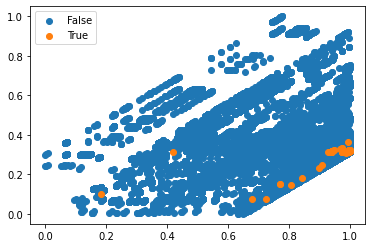

Counter({False: 26824, True: 24141})


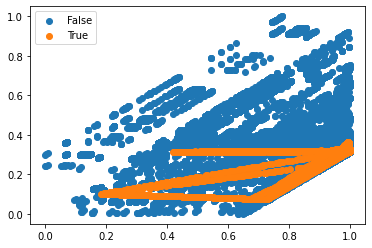

In [129]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE(sampling_strategy=0.9)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.973536   0.074866  0.736842  0.135922  0.26616  0.091265   

   Average Precision  
0           0.055908  

--------------------------------------------------------------------


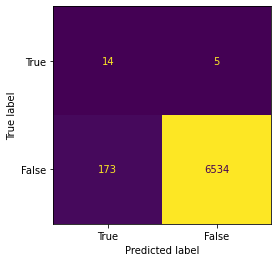

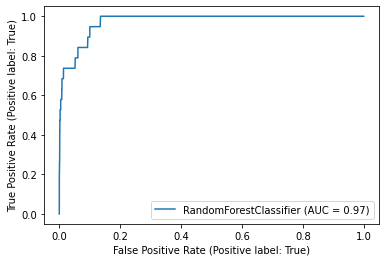

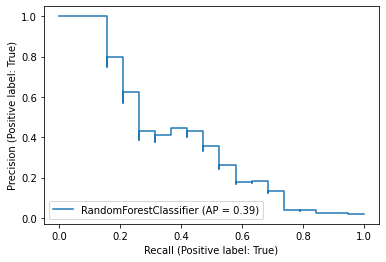

In [125]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# Train the model on training data
rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=[processedData_MxShopFeatureNames])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

In [ ]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# OLD Model Pipeline - Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier(n_jobs=-1, n_estimators = 3400, max_depth = 25)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# Model - Pipeline for GXBoost

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.1, n_jobs=2)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict()
space['classifier__n_estimators'] = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
space['classifier__max_depth'] = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
space['classifier__subsample'] = [0.7, 0.8, 0.9, 1.0]
space['classifier__learning_rate'] = [0.17, 0.18, 0.19, 0.2]
space['classifier__colsample_bytree'] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__gamma'] = [0.01, 0.02, 0.03, 0.04, 0.05]

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:36:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1714.155 seconds
Cross-validation score: 0.8329283861320473
Test score: 0.7971014492753623
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.9, 'classifier__colsample_bytree': 0.8}
0.017387914
0.023187198
0.048509862
0.0
0.017462779
0.025219457
0.0
0.006787189
0.019125199
0.0
0.04485659
0.014123082
0.0
0.0
0.022169633
0.0
0.01980644
0.0
0.0
0.004699794
0.0
0.0304516
0.008459342
0.0
0.0
0.0
0.0
0.0
0.01864229
0.009701973
0.0
0.0
0.007284407
0.0
0.008559288
0.0
0.0
0.0
0.0054326775
0.0076253614
0.021018364
0.0045094118
0.009215939
0.065427035
0.0
0.0
0.01086

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1618.755 seconds
Cross-validation score: 0.812616059962336
Test score: 0.7894736842105263
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.4, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.2}
0.028700061
0.019924155
0.04620611
0.0
0.029158324
0.008901393
0.0012772494
0.0
0.03670984
0.0
0.0
0.0
0.0
0.0
0.0
0.010975686
0.018276574
0.018458815
0.0
0.0031972472
0.0
0.0541827
0.004209339
0.0
0.0
0.0
0.0
0.0
0.020526579
0.0063623367
0.0
0.0026566624
0.013646889
0.0
0.0026239045
0.0
0.0
0.0018711269
0.03195529
0.0033116774
0.0059462884
0.0033635774
0.0041981186
0.0048804046


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1700.347 seconds
Cross-validation score: 0.8451379149135111
Test score: 0.8771929824561404
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.7}
0.04305141
0.03253571
0.06776076
0.0
0.063236825
0.022156537
0.0
0.0
0.0
0.0
0.04552217
0.0
0.0
0.0
0.036197696
0.0
0.030235296
0.0
0.0
0.0
0.0
0.04291311
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.008531175
0.0
0.0
0.002607935
0.0
0.0
0.0
0.0
0.005941722
0.0
0.006878799
0.003185988
0.0028261805
0.0
0.0
0.0029886693
0.007863231
0.0070824022
0.0
0.0
0.0
0.008364263
0.0
0.0
0.0
0.0
0.0
0.0
0.0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1693.036 seconds
Cross-validation score: 0.7819290192841533
Test score: 0.7692307692307693
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.6, 'classifier__gamma': 0.9, 'classifier__colsample_bytree': 1.0}
0.018321674
0.011427668
0.07320425
0.0
0.06969615
0.05986972
0.0
0.0
0.0
0.0
0.0
0.0048500607
0.0
0.0
0.030021489
0.0
0.0
0.0
0.0
0.0
0.0
0.033028778
0.009853025
0.0
0.0
0.0
0.0
0.0
0.0
0.018616185
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.014439625
0.005660434
0.0057602297
0.0
0.0
0.0
0.0
0.013808179
0.0
0.0
0.0
0.010828089
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.008626336
0.09277732
0.0917

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1652.403 seconds
Cross-validation score: 0.8420020559424117
Test score: 0.8490566037735848
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.6, 'classifier__colsample_bytree': 0.5}
0.027378984
0.019352203
0.06106192
0.0
0.045794737
0.011398567
0.0
0.014269077
0.005214672
0.0
0.0
0.0
0.0
0.0
0.04700637
0.0
0.011909109
0.0
0.0
0.0
0.0
0.030685144
0.0066121356
0.0
0.0
0.0
0.0
0.0
0.0
0.0032676975
0.013463228
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016592238
0.022416908
0.0027764994
0.0
0.0
0.0044440073
0.0
0.010496521
0.0
0.0
0.0
0.004024052
0.010383188
0.010850504

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1949.293 seconds
Cross-validation score: 0.8544511078651478
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.9}
0.011964898
0.020147132
0.020765206
0.0036705537
0.010681295
0.0051673036
0.0048464285
0.0
0.0
0.0044154427
0.016146477
0.005720252
0.006463113
0.0
0.018661149
0.0
0.0046562445
0.004954382
0.0
0.01486986
0.007704909
0.01792364
0.00954417
0.0
0.0
0.0
0.0
0.010584864
0.03416566
0.0052332366
0.011111981
0.0064512673
0.007440527
0.0037929206
0.008316923
0.0
0.0
0.0
0.006727326
0.03

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:27:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1606.105 seconds
Cross-validation score: 0.8308607345072982
Test score: 0.6923076923076923
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.9}
0.013852312
0.021991381
0.02529348
0.0064459364
0.009085839
0.0071401885
0.0077248183
0.0057944916
0.0
0.0
0.016114192
0.0077724247
0.0
0.0
0.013585351
0.0
0.026177995
0.0053041195
0.0085494565
0.0
0.016108792
0.020037362
0.006253135
0.0
0.0
0.0
0.0
0.007221951
0.0052839317
0.0
0.011152011
0.010125635
0.02330602
0.005960173
0.0054214844
0.0
0.008181714
0.0029321357
0.010427045
0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_enco

[09:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 28517.973 seconds
Cross-validation score: 0.8448152447930998
Test score: 0.821917808219178
Best Hyperparameters: {'classifier__min_child_weight': 7, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.7}
0.020442277
0.022578474
0.03483195
0.0
0.017079279
0.011239521
0.014845448
0.010562364
0.0127258
0.0
0.024041107
0.024763223
0.0
0.0
0.0
0.0
0.02457653
0.0
0.0
0.019754268
0.0050282003
0.023262158
0.004965204
0.0
0.0
0.0
0.0
0.0
0.0
0.0048022573
0.0
0.005169628
0.0
0.0
0.010817798
0.0
0.0
0.0074339695
0.0033820278
0.00519671
0.006770644
0.01625578
0.0
0.008761312
0.0064858
0.04

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1549.914 seconds
Cross-validation score: 0.8447236499683536
Test score: 0.7692307692307693
Best Hyperparameters: {'classifier__min_child_weight': 6, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.4, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.4}
0.044589203
0.011195919
0.053482465
0.0
0.034458198
0.00941479
0.0
0.0
0.017626991
0.0
0.018137021
0.0121693155
0.0
0.0
0.0
0.0
0.038313646
0.0
0.0
0.0
0.0039799935
0.022985725
0.007059128
0.0
0.0055490932
0.0
0.0
0.0
0.020949632
0.0
0.0
0.004633479
0.00546894
0.024794381
0.0029285816
0.014234319
0.013712658
0.0044190916
0.0051700817
0.007245103
0.0032266178
0.014191779
0.0
0.005

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:15:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1641.138 seconds
Cross-validation score: 0.8208386987415555
Test score: 0.7894736842105263
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.1}
0.024907924
0.01548107
0.066989526
0.0
0.03585393
0.0073293694
0.0073983036
0.0
0.022302132
0.0
0.0
0.013030985
0.0
0.0
0.0
0.0031123986
0.021928623
0.0
0.009412632
0.020047843
0.02160982
0.02938292
0.0022378308
0.011548985
0.005389054
0.0
0.0
0.028834915
0.0
0.007918232
0.0012933855
0.0
0.0
0.0
0.0
0.0037051335
0.0
0.0023379906
0.028177422
0.014005343
0.007518822
0.014619165
0.

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1545.692 seconds
Cross-validation score: 0.8135269543330367
Test score: 0.7017543859649122
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.6, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.2}
0.09487895
0.01968115
0.049871992
0.0
0.040699225
0.0
0.0027758372
0.0
0.03567971
0.0
0.02418668
0.0
0.0
0.0
0.0
0.020548448
0.030836526
0.0
0.00036433878
0.011061352
0.036743067
0.029931633
0.003312334
0.0
0.0
0.0
0.0
0.007988545
0.0
0.0
0.0
0.0028218797
0.0
0.0
0.0
0.0
0.0
0.0
0.04836955
0.0026637553
0.008313725
0.004504802
0.0
0.017505242
0.0040845345
0.009053304
0.00987915


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:11:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1809.151 seconds
Cross-validation score: 0.8438532438310988
Test score: 0.7692307692307693
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.55, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.8}
0.033821527
0.025295148
0.0694597
0.0
0.084383935
0.01562561
0.0028633005
0.0
0.0
0.0
0.0
0.01948367
0.0
0.0
0.014564526
0.0
0.03712645
0.0
0.0
0.0
0.0
0.06501814
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.018669471
0.0
0.0
0.0018674526
0.0
0.0
0.0
0.0
0.0
0.0
0.02207408
0.0
0.006982547
0.0
0.0
0.01949146
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.012835409
0.0030707899
0.0784470

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1583.404 seconds
Cross-validation score: 0.8102977952907826
Test score: 0.8235294117647058
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.55, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.9}
0.026865477
0.021853345
0.07069253
0.0
0.035447247
0.012481068
0.0
0.0
0.0
0.0
0.06373691
0.0021838585
0.0
0.0
0.022155978
0.0
0.0019551395
0.0
0.0
0.0
0.0068509094
0.027501931
0.006762345
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0023063838
0.0
0.0
0.0147850225
0.0
0.0
0.0
0.018149495
0.0076151304
0.0
0.0030672983
0.0
0.0
0.013740751
0.0
0.008193111
0.0
0.0
0.0
0.016151143
0.002142808

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1618.596 seconds
Cross-validation score: 0.8199244605201643
Test score: 0.7894736842105263
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.6}
0.033392563
0.012475201
0.07779989
0.0
0.028814366
0.054323703
0.0
0.0
0.0
0.0
0.0
0.01416785
0.0
0.0
0.030374665
0.0
0.041917752
0.0
0.0
0.0
0.0
0.030527635
0.004510073
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.008874037
0.008879763
0.0057724556
0.0055293515
0.0
0.0
0.0
0.0041156104
0.0
0.0
0.0
0.010293523
0.0
0.013846825
0.0
0.0
0.0
0.0100260535
0.0
0.0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1577.642 seconds
Cross-validation score: 0.8497299622751753
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.45, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.5}
0.021560512
0.027839275
0.051766373
0.0
0.030643342
0.018056085
0.0
0.0
0.0
0.0
0.0
0.0044640508
0.0
0.0
0.0
0.0
0.019562054
0.0
0.0
0.0
0.0
0.03433429
0.004048693
0.0
0.0
0.0
0.0
0.0
0.0
0.00678215
0.0032386028
0.0032997862
0.0
0.0
0.01690284
0.0
0.0
0.0
0.0017157439
0.020879833
0.009221524
0.0025563424
0.0
0.022975344
0.005690689
0.007867163
0.0029576393
0.0
0.0
0.0
0.00714723

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1463.951 seconds
Cross-validation score: 0.8446542141972865
Test score: 0.7142857142857142
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.1}
0.026732758
0.037726726
0.06077956
0.0
0.017914757
0.008229824
0.015086775
0.0
0.016408673
0.0
0.0
0.013863689
0.019972391
0.0
0.0
0.004130502
0.013439454
0.01399612
0.0045120697
0.008067756
0.015026296
0.030410785
0.0030196575
0.0
0.008142442
0.0062180515
0.0
0.0
0.0
0.006456691
0.0
0.0027621996
0.0017594278
0.005756169
0.0072576
0.0026513415
0.016707871
0.005406138
0.022539593

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1552.473 seconds
Cross-validation score: 0.8542276096974553
Test score: 0.7547169811320755
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.6, 'classifier__colsample_bytree': 0.5}
0.024931524
0.03822822
0.04687051
0.0
0.01965612
0.02132261
0.014990511
0.0
0.0077291424
0.0
0.036588494
0.016875412
0.0
0.0
0.017739933
0.0
0.0029495233
0.0
0.0
0.0
0.0
0.015647806
0.005741821
0.0
0.0
0.0
0.0
0.0
0.0
0.011229184
0.0
0.0
0.011563364
0.0
0.0
0.0
0.0
0.0
0.0058031385
0.007931607
0.012196987
0.045818765
0.0
0.015322033
0.0073864046
0.020241577
0.011707165
0.0
0.0


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1615.634 seconds
Cross-validation score: 0.8458783990820603
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.5, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.1}
0.025749452
0.004644315
0.05867049
0.0
0.03516347
0.0045514656
0.009686741
0.0
0.04512978
0.0
0.0
0.0
0.020791376
0.0
0.0
0.013732168
0.020636719
0.0
0.0
0.045236383
6.9532085e-05
0.036768816
0.0
0.014264507
0.0
0.0
0.0033193193
0.0
0.0
0.0039813183
0.0
0.0
0.0
0.0
0.005506706
0.0
0.0
0.0
0.0034413298
0.012234182
0.011307478
0.008440884
0.019843698
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1316.469 seconds
Cross-validation score: 0.85719565122754
Test score: 0.7547169811320755
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.4}
0.03427433
0.024026891
0.059154663
0.0
0.02670473
0.01309761
0.0032554117
0.017992172
0.012032217
0.0
0.025996964
0.0153171485
0.0
0.0
0.021596195
0.0
0.007035267
0.0
0.0
0.0
0.0
0.026622672
0.0068079936
0.0
0.0
0.0
0.0
0.0
0.0
0.006192505
0.0
0.0
0.0
0.0
0.011458404
0.002992041
0.0
0.015967546
0.0
0.0050261426
0.00918426
0.0038674907
0.0
0.0
0.01098137
0.013812696
0.0063290223
0.

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1618.109 seconds
Cross-validation score: 0.8548806139195155
Test score: 0.7894736842105263
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.4, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.4}
0.053036023
0.025047049
0.049370904
0.0
0.03856293
0.0
0.0
0.0
0.0
0.0
0.021348845
0.014576314
0.0
0.0
0.036042333
0.0
0.0
0.0
0.0
0.0
0.0
0.014758381
0.0084349075
0.0
0.005643399
0.0
0.0
0.0
0.0
0.009489514
0.0
0.0030900752
0.008831001
0.0
0.0
0.0
0.0
0.00019795279
0.0
0.011011216
0.0033490395
0.004884226
0.0
0.022805437
0.012400437
0.0
0.012034617
0.0
0.0
0.0
0.0
0.0
0.0020313

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1590.350 seconds
Cross-validation score: 0.8464678721894343
Test score: 0.8490566037735848
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.7}
0.019652613
0.031945977
0.049260207
0.0
0.030905545
0.0281318
0.003397284
0.0077405185
0.0
0.0
0.052933987
0.02028257
0.0
0.0
0.0
0.0
0.026101062
0.0
0.0
0.0
0.0
0.018232187
0.007995358
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.027188566
0.007074063
0.0
0.0
0.0
0.0
0.0
0.003278768
0.009361759
0.017897118
0.0056759757
0.0
0.0
0.013334361
0.0
0.0
0.0
0.0
0.0
0.0064019533
0.0
0.0
0.0
0.0
0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1655.128 seconds
Cross-validation score: 0.8129378104760109
Test score: 0.8163265306122449
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.4}
0.026006244
0.022046484
0.045029353
0.0
0.019284198
0.017917275
0.01033071
0.007340756
0.0101024825
0.0
0.014959042
0.02415356
0.0
0.0
0.016830893
0.0
0.01412655
0.0
0.0
0.0
0.05137559
0.020309493
0.0042034127
0.012052975
0.0
0.0
0.0
0.0
0.0
0.010477022
0.0
0.0
0.004926236
0.0
0.0
0.0073308377
0.0
0.0
0.0031581637
0.007556921
0.008704364
0.0
0.0
0.0
0.0060570766
0.023115661
0.0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1610.341 seconds
Cross-validation score: 0.8205601271372291
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.6}
0.011550461
0.011604438
0.02895118
0.013118866
0.0100187855
0.009646072
0.0
0.0
0.0033081407
0.0
0.010277249
0.007582264
0.0067554377
0.0
0.014296851
0.0
0.006252659
0.0032773053
0.0003319789
0.011039456
0.0034187606
0.0014939051
0.01355025
0.003963089
0.0060328627
0.0
0.0
0.0059904745
0.005005407
0.0067595853
0.0074776006
0.009531767
0.008361477
0.0033710464
0.0046621943
0.0081

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1604.186 seconds
Cross-validation score: 0.8153019444596916
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.2}
0.027775861
0.013272541
0.045608334
0.0
0.022138378
0.017839454
0.0
0.0
0.013191399
0.0
0.03345795
0.0076160557
0.0
0.0
0.022416987
0.0029436173
0.0072338195
0.0
0.0050097983
0.007875052
0.009264523
0.008814718
0.002067263
0.0
0.010246973
0.0
0.055512976
0.0
0.006830457
0.008872026
0.0
0.001894556
0.0
0.0
0.007602263
0.011005656
0.0
0.0
0.0
0.0132987965
0.0061636777
0.0016034539

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1633.971 seconds
Cross-validation score: 0.8478528673959396
Test score: 0.9016393442622951
Best Hyperparameters: {'classifier__min_child_weight': 6, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.9, 'classifier__colsample_bytree': 0.1}
0.035369776
0.014893533
0.06803456
0.0
0.02939984
0.0036060254
0.011022779
0.0
0.02052114
0.0
0.0
0.0047865217
0.0
0.022504857
0.008618528
0.005266931
0.012935544
0.0
0.0
0.016192578
0.020130567
0.020178556
0.022035925
0.0165817
0.009085895
0.0
0.00216698
0.0
0.0
0.009083301
0.0
0.008643912
0.0
0.0054228567
0.0035533593
0.0062441174
0.023199294
0.004024435
0.003312061
0.00933178

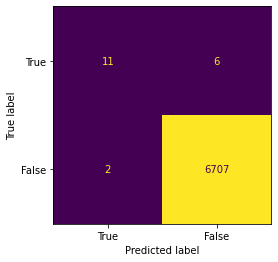

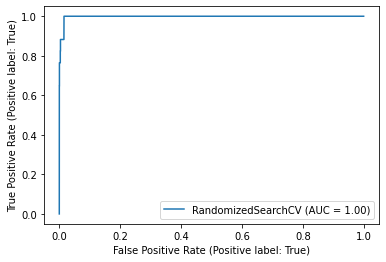

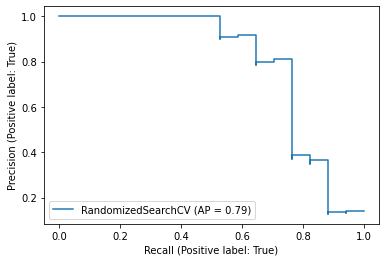

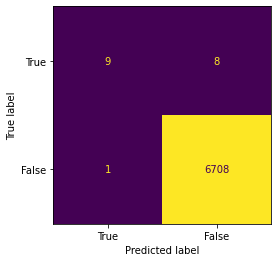

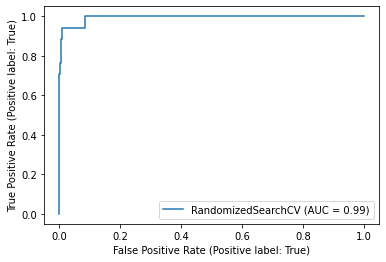

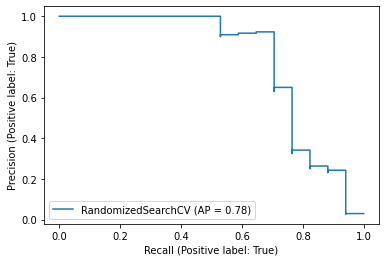

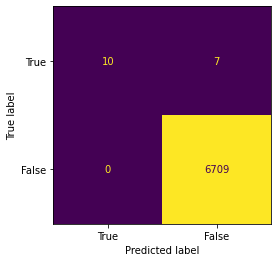

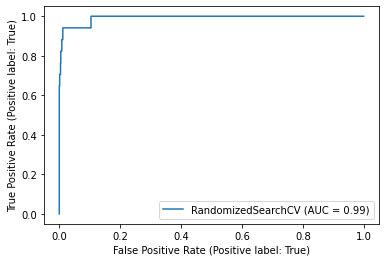

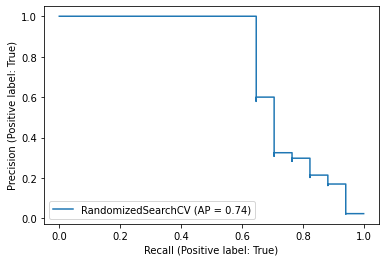

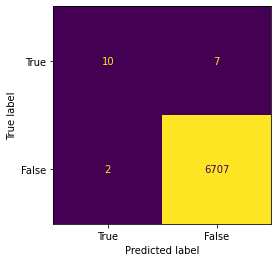

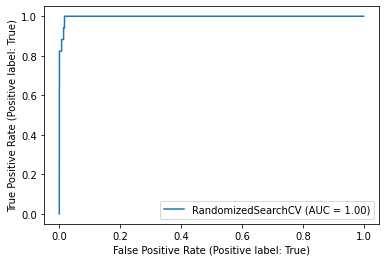

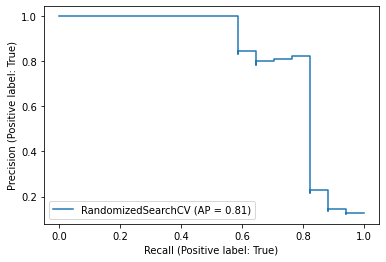

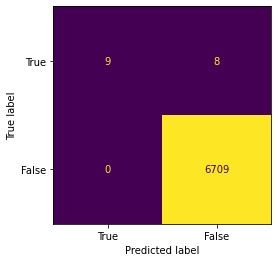

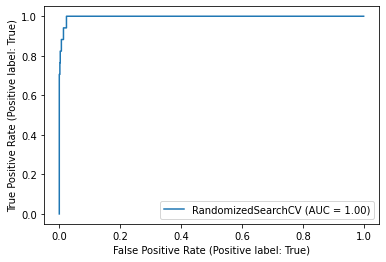

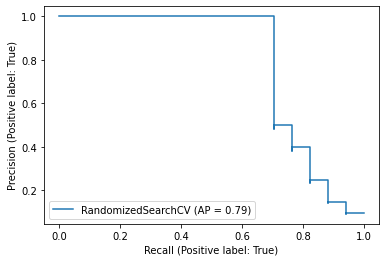

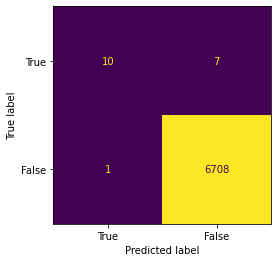

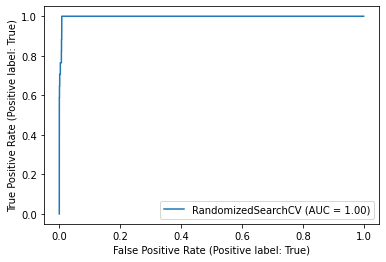

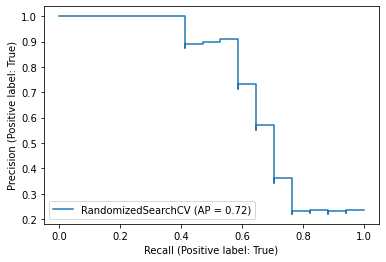

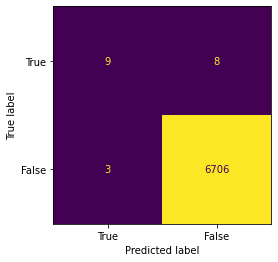

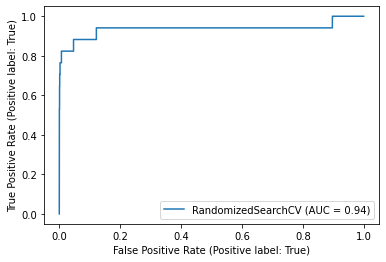

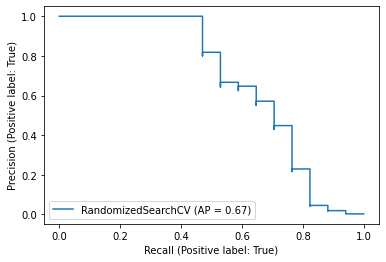

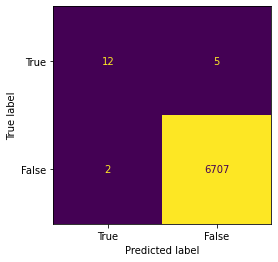

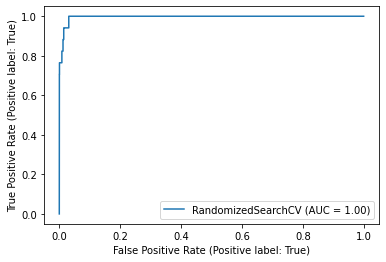

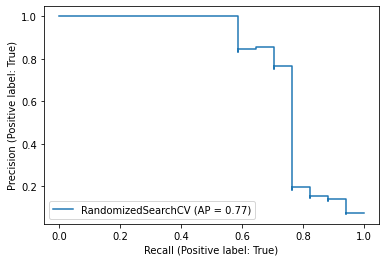

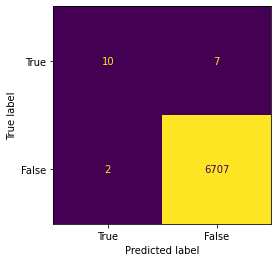

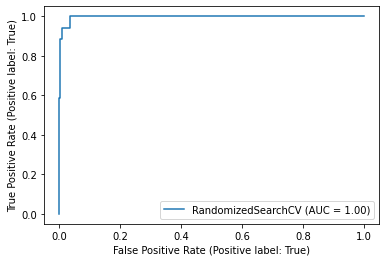

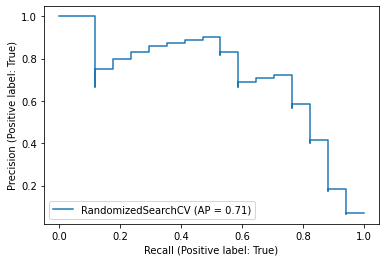

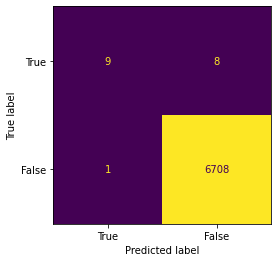

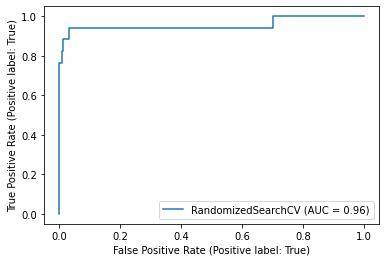

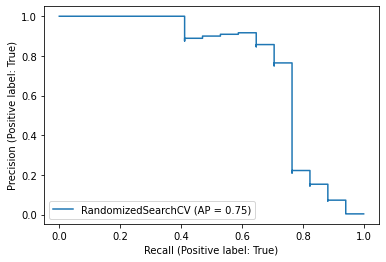

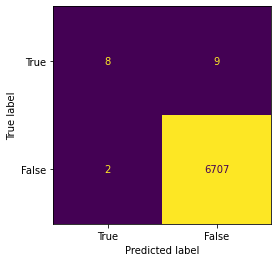

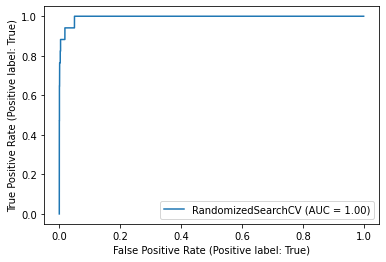

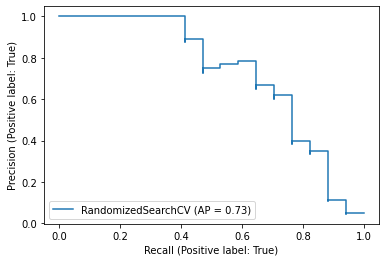

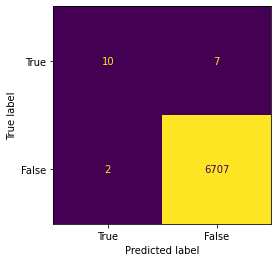

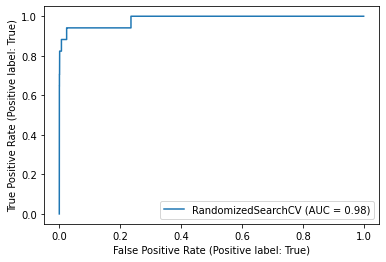

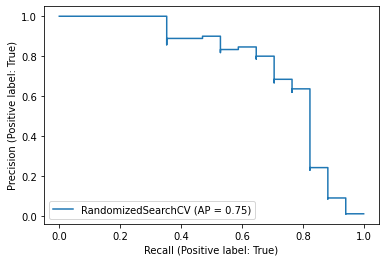

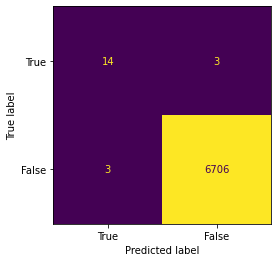

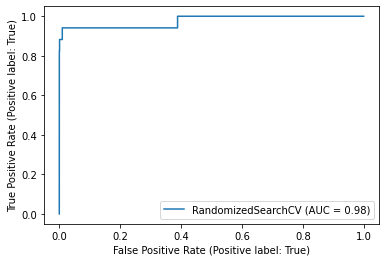

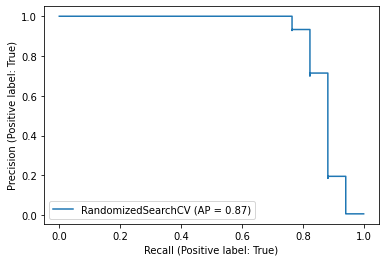

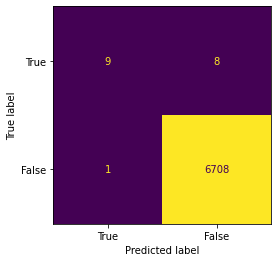

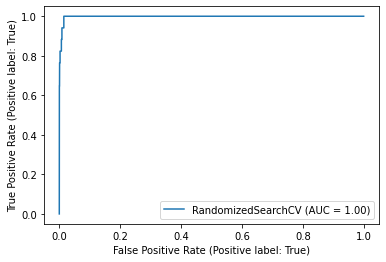

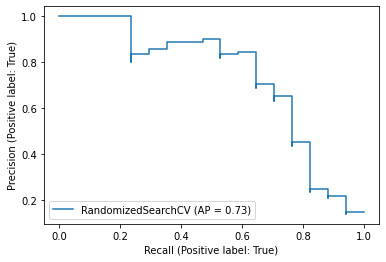

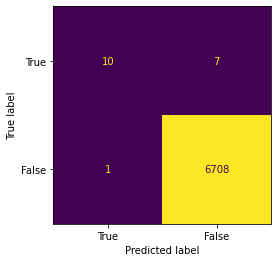

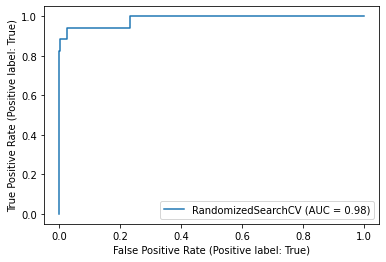

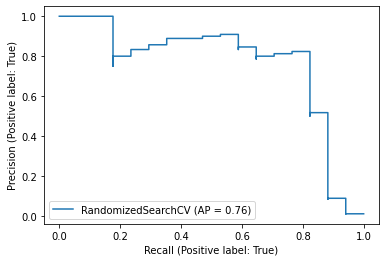

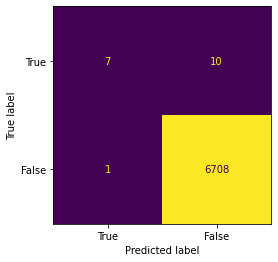

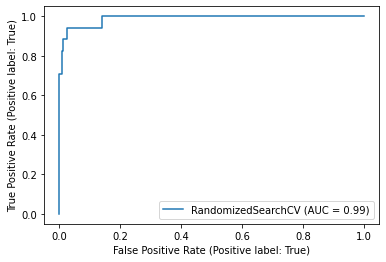

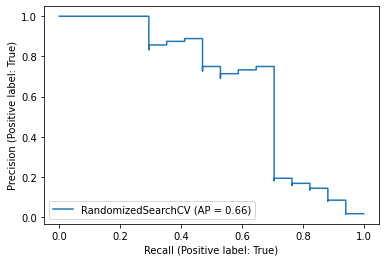

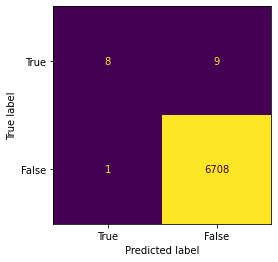

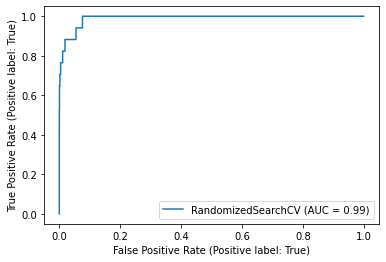

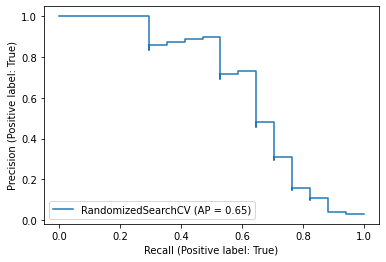

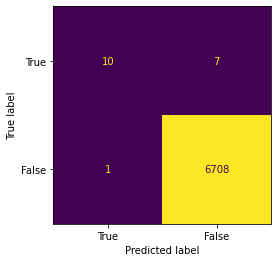

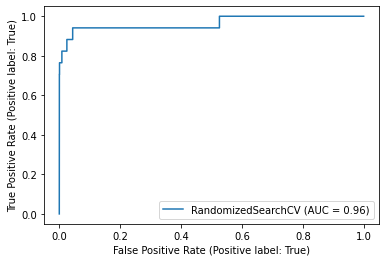

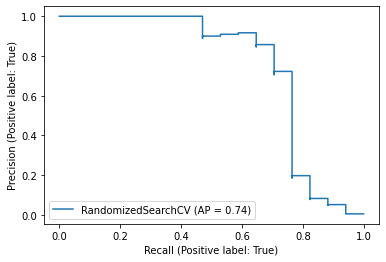

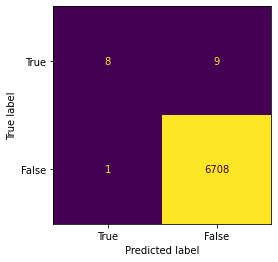

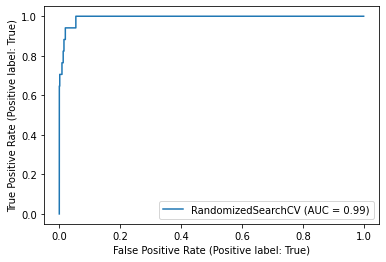

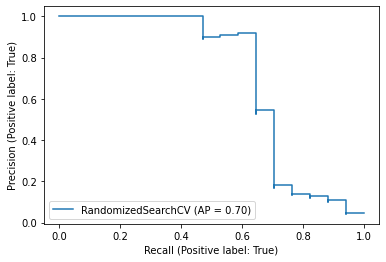

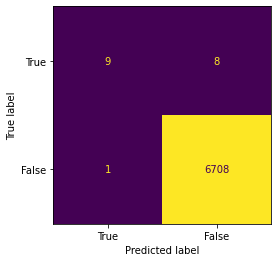

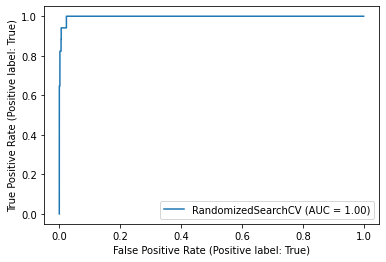

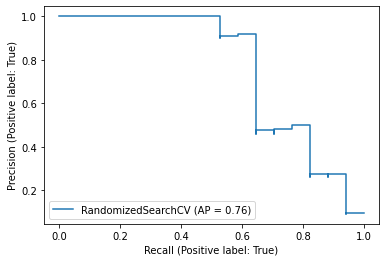

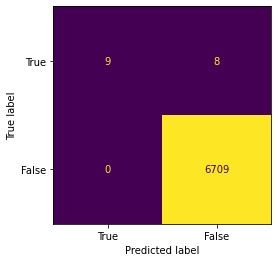

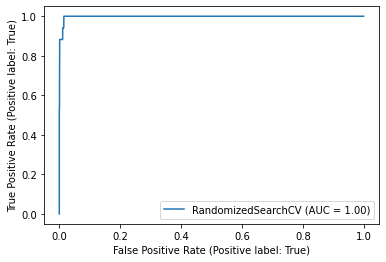

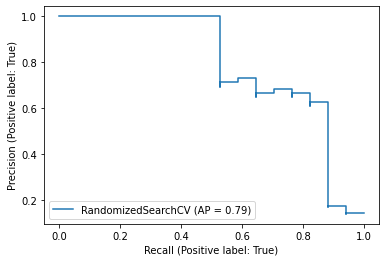

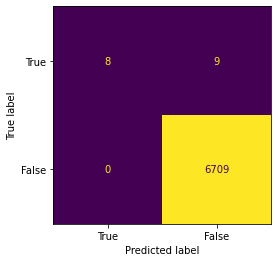

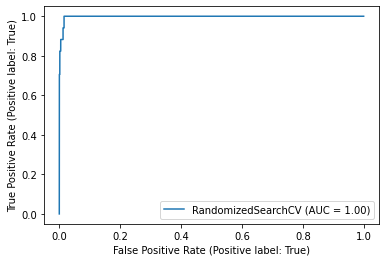

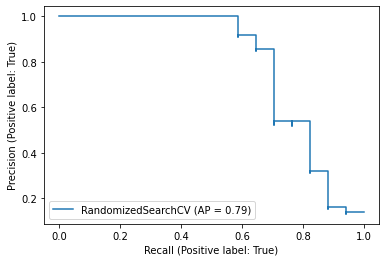

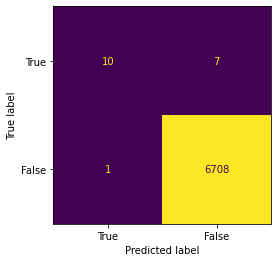

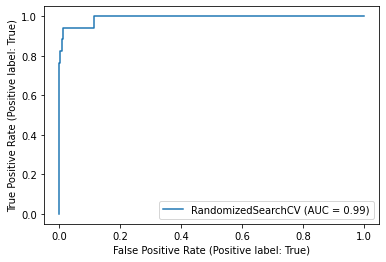

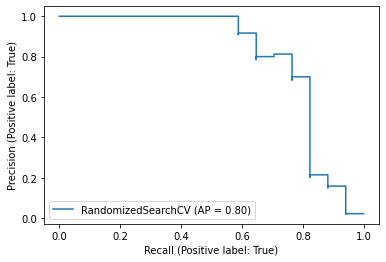

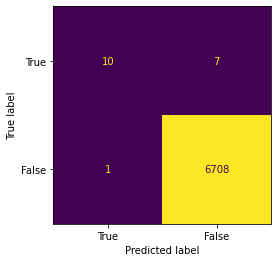

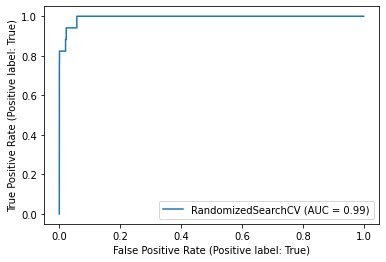

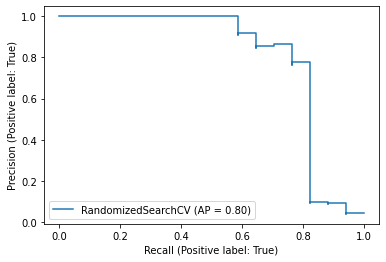

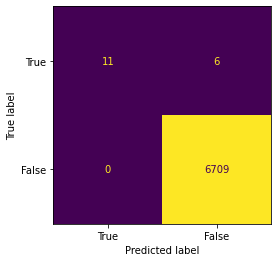

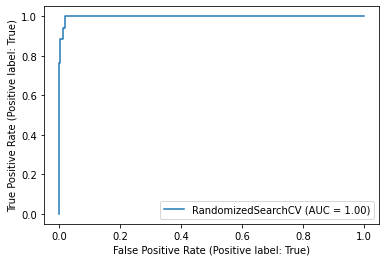

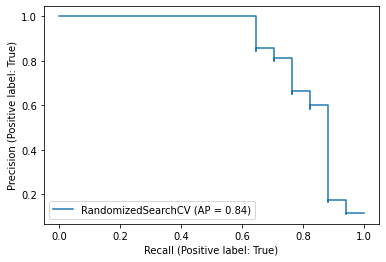

In [9]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

for i in range(25):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
    space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    spaceEmpty = dict()

    GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring=fhalf_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    
    cv_score = optimizedGXBoostModel.best_score_
    test_score = optimizedGXBoostModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)
    
    #feature importance
    importances = optimizedGXBoostModel.best_estimator_._final_estimator.feature_importances_
    for i,v in enumerate(importances):
        print(v)

    #Display the model performance    
    showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for Random Forests

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


pipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=0.1, n_jobs=2)],
                             ['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict() 
space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
space['classifier__min_samples_split'] = [1, 2, 3]


search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedRFModel = search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedRFModel.best_score_
test_score = optimizedRFModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.256 seconds
Cross-validation score: 0.08045029396404753
Test score: 0.06435643564356436
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0    0.9438   0.033592  0.764706  0.064356  0.142857  0.041534   

   Average Precision  
0           0.026283  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.280 seconds
Cross-validation score: 0.0654886628710359
Test score: 0.08808290155440415
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision  Recall        F1        F2      F0.5  \
0  0.947666    0.04607     1.0  0.088083  0.194508  0.056932   

   Average Precision  
0            0.04607  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.225 seconds
Cross-validation score: 0.05817922529830365
Test score: 0.06779661016949153
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.934582   0.035165  0.941176  0.067797  0.152964  0.043549   

   Average Precision  
0           0.033245  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.281 seconds
Cross-validation score: 0.06890022103334739
Test score: 0.09115281501340483
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision  Recall        F1        F2      F0.5  \
0  0.949599   0.047753     1.0  0.091153  0.200472  0.058987   

   Average Precision  
0           0.047753  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.264 seconds
Cross-validation score: 0.06996407967359262
Test score: 0.09065155807365437
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2     F0.5  \
0  0.952275   0.047619  0.941176  0.090652  0.19802  0.05878   

   Average Precision  
0           0.044967  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.187 seconds
Cross-validation score: 0.09186018094752672
Test score: 0.07669616519174041
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.953464   0.040373  0.764706  0.076696  0.166667  0.049808   

   Average Precision  
0           0.031468  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.201 seconds
Cross-validation score: 0.07722779745909472
Test score: 0.07289293849658315
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.939489   0.037915  0.941176  0.072893  0.163265  0.046921   

   Average Precision  
0           0.035833  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.287 seconds
Cross-validation score: 0.05995772761371461
Test score: 0.08076009501187649
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision  Recall       F1        F2      F0.5  Average Precision
0  0.942462   0.042079     1.0  0.08076  0.180085  0.052051           0.042079

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.260 seconds
Cross-validation score: 0.06325532869113179
Test score: 0.08839779005524862
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.950937   0.046377  0.941176  0.088398  0.193705  0.057266   

   Average Precision  
0           0.043797  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.343 seconds
Cross-validation score: 0.08243952992119516
Test score: 0.07633587786259542
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2     F0.5  \
0   0.94603   0.039894  0.882353  0.076336  0.168919  0.04931   

   Average Precision  
0           0.035498  

--------------------------------------------------------------------


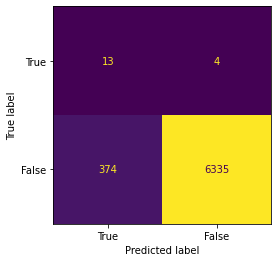

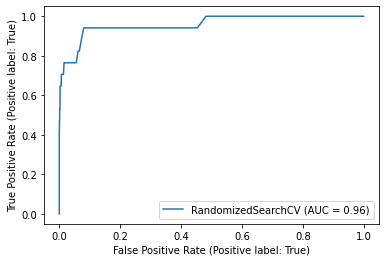

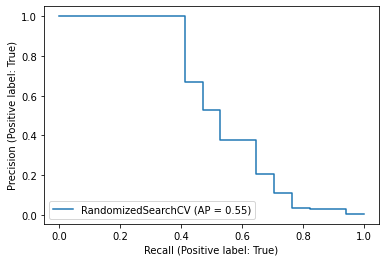

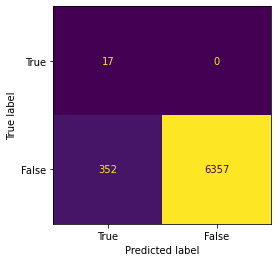

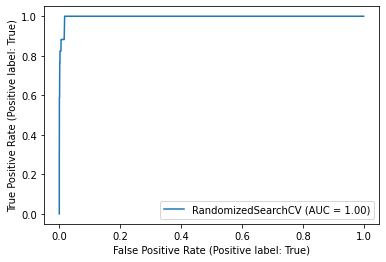

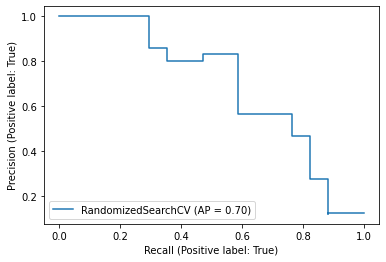

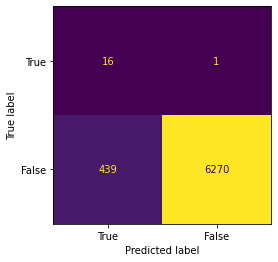

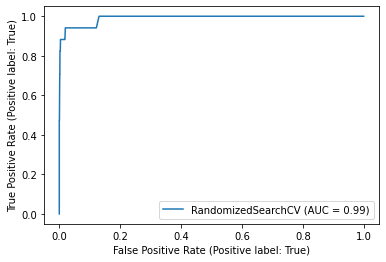

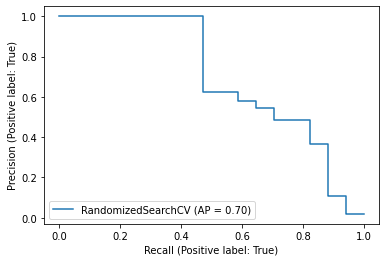

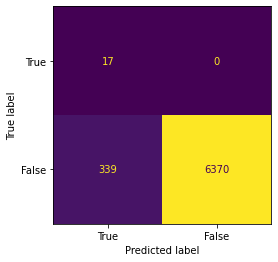

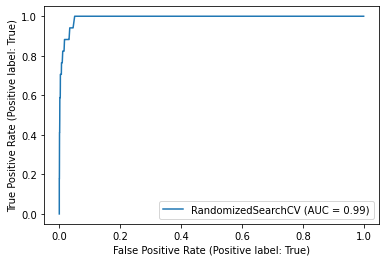

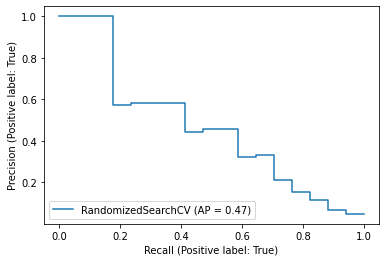

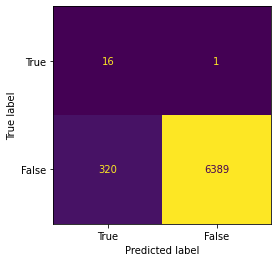

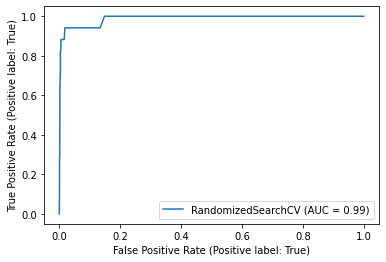

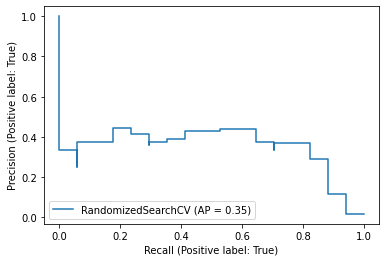

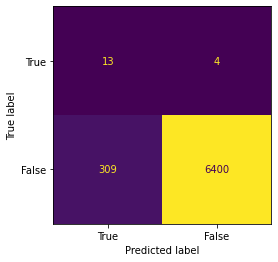

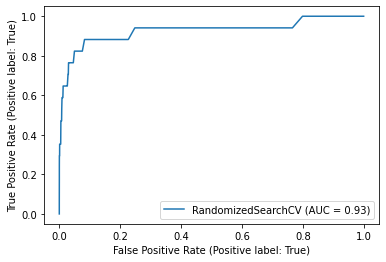

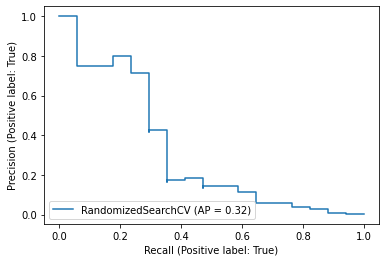

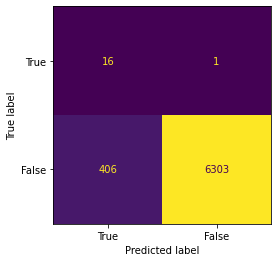

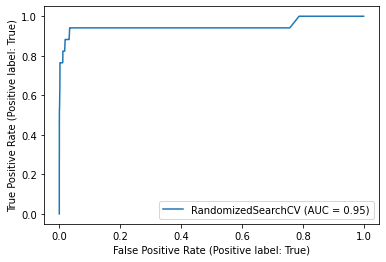

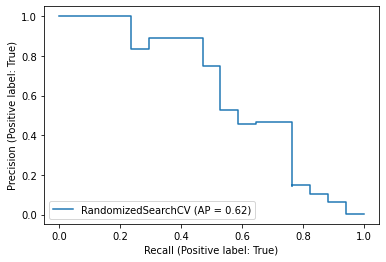

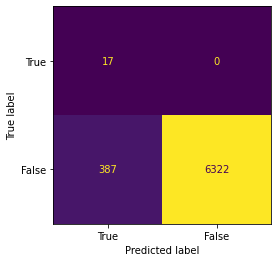

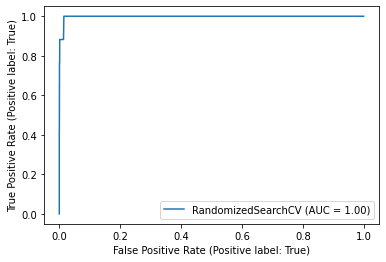

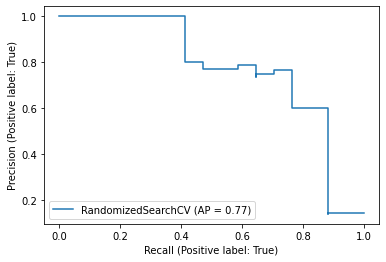

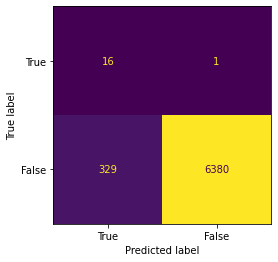

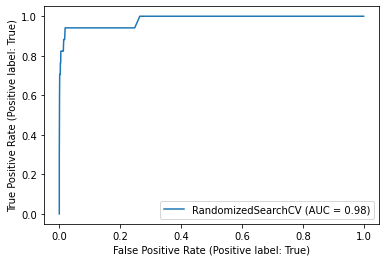

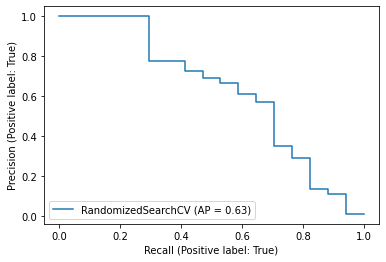

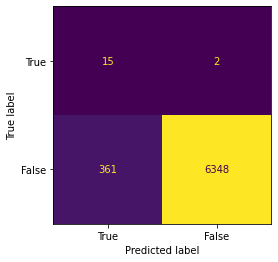

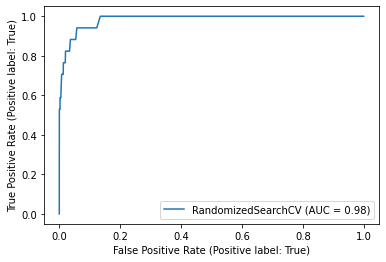

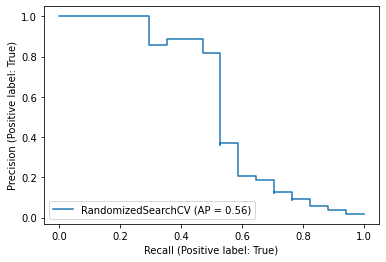

In [34]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier



for i in range(10):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    pipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                             #['under', RandomUnderSampler()],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    spaceEmpty = dict() 
    space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
    space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
    space['classifier__min_samples_split'] = [1, 2, 3]


    search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

    optimizedRFModel = search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
          f"{elapsed_time:.3f} seconds")
    cv_score = optimizedRFModel.best_score_
    test_score = optimizedRFModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

ftwo_scorer = make_scorer(fbeta_score, beta=2)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sn_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict()
space['classifier__num_leaves'] = [60, 70, 80, 90, 100]
space['classifier__max_depth'] = [5, 6, 7, 8]
space['classifier__min_data_in_leaf'] = [250, 500, 750, 1000, 1250, 1500]


LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedLightGBMModel.best_score_
test_score = optimizedLightGBMModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 10.538 seconds
Cross-validation score: 0.6264410216616099
Test score: 0.6666666666666666
Best Hyperparameters: {}
2989.269416898489
9464.777064409107
20390.80891052261
357.0654403604567
374.6164860986173
2.120678022503853
75.75183728337288
0.0
97.73566436767578
0.0
68993.00540528446
9.357035964727402
35.05737920105457
0.0
16.08256161212921
0.39265701174736023
6.574898988008499
0.0
26.134904086589813
6.49963191151619
225.15520949661732
6.601528972387314
2.5760431066155434
0.23458300530910492
6.250490069389343
3.732965908944607
107.02457144856453
1564.2893342375755
322.73797392100096
18.302744925022125
23.733988106250763
105.63413555920124
490.7279713228345
0.0
0.0
0.0
1795.25753428787
4044.1877567842603
972.8930593207479
226.79396417737007
142.80571928620338
12929.941097326577
32.12706772983074
82.88838873803616
25.98635696619749
0.0
0.0
0.0
372.3494152724743
42.92797479778528
194.059197653085
9.792446166276932
0.4154912158846855
0.2911139950156212
60.6

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 10.696 seconds
Cross-validation score: 0.6866514954750249
Test score: 0.5232558139534884
Best Hyperparameters: {}
1232.5417571738362
17300.320513159037
101847.77094550803
3599.463199917227
381.202336139977
71.68229481577873
0.0
0.0
0.07710970193147659
2.2398659735918045
11363.961714357138
21.919180616736412
1.051154874265194
0.0
341.4892052412033
0.3715235963463783
288.09382013976574
8.438870072364807
4.194295912981033
0.3154340088367462
32.409706730395555
701.0025315284729
18.59933741390705
0.848438024520874
24.315081544220448
31.172330021858215
32.04719924926758
1092.2567980140448
11.259265713393688
10.659847214818
8.281560972332954
1502.7240285538137
1116.8888328745961
0.0
0.0
0.0
384.03106439858675
765.8532680571079
103.06626908481121
46.65611159801483
25.721187701448798
2890.5137618258595
51.604359433054924
0.35321179032325745
28.748916998505592
0.0
0.0
0.0
60.447511333972216
47.39018675684929
62.27967598289251
10.482140064239502
0.0
0.93443398177

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 12.216 seconds
Cross-validation score: 0.6729837043018321
Test score: 0.4878048780487805
Best Hyperparameters: {}
10281.391746781766
2858.9995985366404
83412.25856544264
3869.361838951707
42.508438762277365
27.831203117966652
371.7979716844857
0.05282609909772873
427.96967563033104
2.3254098892211914
45347.14892152324
1.8853605911135674
5.748992074280977
0.0
7.082636922597885
0.0
1.0624240040779114
0.0
22.007405512034893
7.5669329315423965
94.55325078964233
123.0524183139205
2.6667075231671333
0.0
2.0318783298134804
11.135830849409103
29.65803575515747
203.82846483960748
537.2801653444767
26.987665589898825
11.7417813539505
98.46419151127338
85.16541131585836
0.0
0.0
0.0
316.16319689154625
8048.2831111475825
144.76887671276927
270.0873421058059
66.36596722900867
243.26884902641177
129.2461450845003
0.0
347.7781267724931
0.0
0.0
0.0
619.0542103648186
35.97191779688001
523.5364526323974
49.34738130867481
46.81979942321777
35.339771419763565
95.8627566322

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 12.145 seconds
Cross-validation score: 0.5537619991479973
Test score: 0.7692307692307693
Best Hyperparameters: {}
22754.34352120012
9502.215084582567
23691.01034910232
5588.0189903602
41.970188699662685
48.70334856957197
98.1489765048027
0.0
18.826099395751953
0.16300299763679504
71254.75489339978
17.616027541458607
3.5139569267630577
0.0
1.1155917942523956
0.0
0.36584600806236267
0.0
16.39825004339218
1.0446780025959015
101.89233608543873
155.22269025444984
22.237875133752823
5.850750982761383
15.868994787335396
21.319298945367336
15.623822316527367
1206.4094660431147
501.87124222517014
37.96109014749527
112.02893198281527
200.47449814528227
376.1340202242136
0.0
0.0
0.0
43.59414738416672
5320.976525604725
127.365070566535
360.23149913549423
374.31654646992683
2491.517360858619
135.68839471787214
6.317288815975189
453.8729504495859
0.0
0.0
0.0
120.43060985952616
87.6643101759255
330.0646065995097
25.311852395534515
3.142987072467804
61.607929065823555

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 10.634 seconds
Cross-validation score: 0.5874452228070648
Test score: 0.6818181818181818
Best Hyperparameters: {}
4873.565789952874
2775.235571425408
108135.59682864696
22156.40820846334
251.0832795202732
7.951284050941467
0.07135680317878723
9.051402032375336
0.732774019241333
0.0
24737.245993711054
9.00903706252575
0.9176960289478302
0.0
0.2102452963590622
2.8482679575681686
4.7231314070522785
0.767104983329773
43.54860396683216
3.1081739366054535
63.26945826411247
405.86524322628975
0.11972200125455856
0.0
33.04173105955124
0.0
0.0
38.89461950212717
21.449734300374985
21.965409874916077
171.6297126635909
158.01534070074558
541.7427524738014
0.0
0.0
0.0
118.8657357096672
3829.886041253805
338.1267506033182
82.69518618285656
667.7966054230928
462.4499652944505
78.62346971035004
49.564415100961924
267.8550981283188
0.0
0.0
0.0
63.21491575986147
17.38196486234665
204.7937545068562
1.1912181600928307
1.2981200218200684
0.3995339870452881
13.6959790103137

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 10.858 seconds
Cross-validation score: 0.6342606656074148
Test score: 0.5747126436781609
Best Hyperparameters: {}
868.8358973003924
394.0141355097294
136890.74537615478
22128.59881560877
324.06180508062243
8.142358727753162
17.701384589076042
0.06206019967794418
1.7342300415039062
0.0
4160.4946475327015
0.3608360029757023
0.4074098989367485
0.0
110.37403032183647
2.336250066757202
4.522236905992031
0.495963990688324
22.787779107689857
11.550970077514648
0.8184758052229881
73.851975440979
0.6384270191192627
0.06484130024909973
50.30690383166075
36.78424048423767
40.089574843645096
85.40595760941505
0.1271519958972931
72.41061994805932
53.6277419924736
75.81207605078816
576.3998059500009
0.0
0.0
0.0
344.4538424871862
605.5337309539318
258.78883212059736
18.9658205807209
7.179132621735334
182.98518459498882
16.301176995038986
2.7326720505952835
2.0532218664884567
0.0
0.0
0.0
57.957074496895075
251.87921402603388
31.68931159004569
188.9224761351943
0.0
1.4

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 11.056 seconds
Cross-validation score: 0.6633599807905947
Test score: 0.625
Best Hyperparameters: {}
27352.038704551756
7877.680828016251
5167.674360450357
819.6077737659216
27.43553014099598
1.3489849865436554
1.5039499998092651
0.0
336.93872970342636
8.419079780578613
91227.55895769596
0.6449590027332306
16.95131154358387
0.0
6.187712907791138
0.4059249982237816
0.0
115.51555799692869
6.903039902448654
55.76747107505798
207.56097401678562
132.7997110337019
868.9751908928156
83.15953969955444
12.382936090230942
0.2615459933876991
8.378590106964111
1169.1807173341513
129.67121201753616
0.7400120049715042
22.45796848833561
41.287264600396156
378.24529964104295
0.0
0.0
0.0
269.4281468242407
2753.4940060973167
514.4113871455193
640.5368855446577
157.21466387808323
2348.51337685436
168.94887869805098
146.85069915652275
231.53710181638598
0.0
0.0
0.0
196.7322191260755
93.74494316801429
667.6089862585068
12.18733198940754
0.0
37.665101051330566
153.085540875

C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 17.079 seconds
Cross-validation score: 0.6439987351752057
Test score: 0.7303370786516854
Best Hyperparameters: {}
7304.411986880004
4073.4651615805924
82669.43649227172
1013.7442189119756
133.37845719233155
13.646448761224747
2.097259968519211
6.047885533422232
95.71112728118896
1.7999299764633179
28151.87926107645
1749.285296201706
0.5847370028495789
0.0
7.981058590114117
0.0
0.0
28.641799926757812
2.2024199962615967
216.51282776147127
136.5149319898337
203.99696426466107
18.591289192438126
0.0
0.0
0.0
15.549250796437263
5.32156902551651
0.17937389761209488
596.8877583369613
25.64798590540886
29.769020795822144
460.02702416852117
0.0
0.0
0.0
90.88491196930408
11173.883956588805
71.97507903724909
158.3175132572651
1415.7455619201064
3551.797609180212
51.45657970011234
1.5826287642121315
6041.87298803404
0.0
0.0
0.0
51.02798932790756
53.43459119647741
79.31460504606366
28.58579531311989
7.462203040719032
0.40072399377822876
940.5966502986848
0.866329014

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 16.742 seconds
Cross-validation score: 0.6765358647378866
Test score: 0.6593406593406593
Best Hyperparameters: {}
1251.352574661374
268.3143614269793
126458.87895887904
238.4794312901795
324.9350524842739
13.709828220307827
11.274994730949402
42.568100929260254
26.284409273415804
18.92650032043457
14102.329626597464
4.639711137861013
7.683711022138596
0.0
31.034188747406006
18.004100799560547
187.43831264413893
0.0
0.0
0.0
697.5462768450379
17.557899475097656
20.288700103759766
0.0
0.0
0.0
0.0
2054.4986825212836
161.01870155334473
87.95880828797817
82.00713173300028
111.14729446172714
456.6547158882022
0.0
0.0
0.0
117.06508572399616
12015.8939046897
38.391980186104774
50.53116687759757
53.39375654235482
1374.3939189687371
31.080894015729427
10.855787105858326
1579.4953976869583
0.0
0.0
0.0
36.790717950090766
36.76726046949625
125.84681989066303
1.0222615152597427
0.0980478972196579
0.0
233.19507581740618
24.721631921827793
212.22310990095139
922.725233

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 12.226 seconds
Cross-validation score: 0.7214313745563745
Test score: 0.5487804878048781
Best Hyperparameters: {}
2932.305418305099
2658.84845617041
114749.95189342275
7422.233063273132
88.82168795540929
23.366110365837812
67.98079062253237
0.0
103.6113395690918
0.0
24797.519438058138
47.015451833605766
641.7205638289452
0.0
117.75062145665288
0.0
34.402461141347885
3.2751500606536865
6.38643441349268
22.300747871398926
16.8944720774889
268.7687368988991
107.33254185318947
0.0
0.5688909888267517
0.03664550185203552
46.53940010070801
4732.502717085183
134.64859078079462
0.27769210562109947
87.07111405581236
3319.3641988150775
1639.782713636756
0.0
0.0
0.0
75.32212375849485
3615.1353640928864
187.17050689458847
1328.1010063514113
74.64608781412244
931.0948874652386
82.39192093536258
67.10928754508495
158.01026138290763
0.0
0.0
0.0
101.19032809883356
74.60021851584315
940.4533451423049
40.325439453125
0.0
38.492668233811855
107.50701256096363
6.5411918163

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 10.989 seconds
Cross-validation score: 0.6072965333360515
Test score: 0.7142857142857143
Best Hyperparameters: {}
1774.0443421378732
1073.085653424263
119883.25738564879
27767.90534191951
41.900094993412495
26.618330478668213
16.727678060531616
0.043599698692560196
194.64830231294036
0.5941330194473267
3505.5160234197974
0.5079196020960808
13.9083838686347
0.0
131.7996282428503
0.0
157.95144747197628
7.3881091848015785
0.0
16.108368150889874
53.01062045246363
375.1603600308299
0.047821901738643646
0.0
6.3678746111691
4.409299850463867
2.590100049972534
143.9368026331067
71.66525529325008
22.01212354004383
236.57089199870825
51.99083744734526
21.251483377069235
0.0
0.0
0.0
394.12280839309096
4168.382686249912
172.99833441525698
532.5454832166433
1.785598497837782
4972.3285791277885
296.8009150251746
35.18963560461998
558.5301785096526
0.0
0.0
0.0
26.50217278674245
33.94247916340828
89.81109414622188
29.435839157551527
44.17930941283703
29.11114981770515

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 10.932 seconds
Cross-validation score: 0.6982029298205769
Test score: 0.5617977528089888
Best Hyperparameters: {}
5182.7488101273775
20790.470356609672
105243.48379319161
23.021326065063477
110.55679415166378
0.8788478150963783
12.468734487891197
0.23561400175094604
34.89102567732334
0.0
20296.4748288095
0.6162462905049324
48.92881137132645
0.0
516.5895227193832
0.05383070185780525
252.8154223561287
3.6944899559020996
0.785157885402441
0.04485509917140007
253.0205236673355
558.6701156049967
4.835090704262257
80.28529739379883
1.6100790202617645
0.0
11.03492622077465
364.2482827529311
250.97414155304432
0.6164349913597107
87.4191063940525
416.8204734325409
439.7662380114198
0.0
0.0
0.0
75.08985752239823
1946.213115978986
87.48549281060696
103.5001614689827
36.910358529537916
485.33367348462343
443.29737585783005
113.92726844549179
23.16418819874525
0.0
0.0
0.0
65.98805015161633
41.291881397366524
3535.8401032350957
38.70094344764948
6.214859962463379
81

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 12.447 seconds
Cross-validation score: 0.5978990955282676
Test score: 0.7608695652173914
Best Hyperparameters: {}
7618.519153907895
3861.063295021653
98718.2851665318
239.38590589165688
42.61752625927329
2.357567735016346
2.973856031894684
0.0
116.63460904359818
0.6910119950771332
26928.173697710037
13.303321309387684
1.2959910035133362
0.0
0.10357200354337692
0.3715820014476776
1.8855480551719666
8.165488004684448
1.668138101696968
182.66557610034943
109.83268865942955
41.69666063785553
128.85045368596911
160.63629722595215
30.925057660788298
2.361397922039032
2.776817947626114
476.90706668794155
778.4568013250828
0.0
50.81357853114605
95.20331268012524
119.86080662533641
0.0
0.0
0.0
468.3159478455782
5481.9926500841975
100.64317306131124
553.5750120505691
10.513106375932693
3330.938986569643
107.39720076322556
75.33202175050974
631.115881472826
0.0
0.0
0.0
318.65224082022905
140.9536143168807
673.4076752439141
10.040112629532814
0.6122590154409409
44

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 16.709 seconds
Cross-validation score: 0.6581320215515729
Test score: 0.7065217391304347
Best Hyperparameters: {}
4048.1893301717937
20777.33196644485
20910.060637306422
1149.587037216872
16.705932706594467
57.49239759892225
2.991301015019417
0.0
63.96293932944536
0.13285769894719124
84313.07518201321
6.865340877324343
141.61552623659372
0.0
0.9598829746246338
6.6082199811935425
20.870345294475555
0.0
64.56803000345826
27.999174170196056
16.29631820693612
13.66958138346672
76.99701275676489
18.93440055847168
18.924555234611034
25.920026749372482
17.95918121188879
943.8478287756443
149.43045996129513
156.57436613738537
7.888006556779146
188.65918494015932
409.85483431071043
0.0
0.0
0.0
127.59195329248905
8213.751486083493
177.0988942682743
164.6635580956936
402.06909234821796
1807.237687408924
55.385036528110504
14.680298864841461
106.92160765640438
0.0
0.0
0.0
234.96635795384645
220.29968230053782
263.3598136976361
7.167519107460976
0.6551219820976257


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 17.233 seconds
Cross-validation score: 0.6049004333834055
Test score: 0.7471264367816092
Best Hyperparameters: {}
18173.8788266778
9061.950967859477
28012.399329550564
6064.92741458863
70.70630713552237
137.3752996623516
35.8293906673789
0.15958580374717712
73.32633005082607
1.109279990196228
63908.786664418876
49.90137067437172
305.58738923072815
0.0
11.872428849339485
0.2639564052224159
1.5943610072135925
8.574039936065674
19.81957568973303
3.2482530176639557
113.42260348051786
14.16390597820282
66.31917530298233
0.0
0.4759869948029518
0.8138239979743958
4.152854926884174
529.3567542359233
72.7167939543724
0.2555830031633377
141.1496795937419
141.75270161032677
490.1484931334853
0.0
0.0
0.0
43.45439302921295
3151.8172833919525
53.44462349265814
546.1454157233238
21.40275378525257
1120.098930105567
193.47573600709438
124.66447810083628
88.47420697659254
0.0
0.0
0.0
96.63443068414927
66.15422853827477
249.71750567480922
0.17347319424152374
16.372896656

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 12.971 seconds
Cross-validation score: 0.5917947721353294
Test score: 0.6666666666666666
Best Hyperparameters: {}
6032.354427233338
658.6352736800909
123089.97909695655
264.4386571533978
146.68089146912098
4.815942823886871
0.7318601161241531
0.0
0.12853500247001648
0.04992830008268356
13435.590225920081
414.65939462184906
19.084436397999525
0.0
11.454110033810139
0.0
0.0
1.9394678324460983
0.5653537921607494
12.647203475236893
119.81701342761517
138.07424771040678
0.2016986981034279
25.470074214041233
0.0
34.16520473361015
532.8739895708859
1059.48206897825
5121.268325164914
0.0754811018705368
89.6393711566925
52.320546209812164
475.0757566317916
0.0
0.0
0.0
51.5917699560523
7365.495903715491
68.61053151264787
897.3094007223845
115.65533919259906
115.62916284799576
205.81242924556136
51.59112651646137
381.48666662722826
0.0
0.0
0.0
53.86529494076967
34.55900003015995
1519.3199915401638
1.475152000784874
0.0
18.44117320328951
13.89410351216793
9.316224

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 11.073 seconds
Cross-validation score: 0.6985967463908641
Test score: 0.6470588235294119
Best Hyperparameters: {}
2184.271187324077
507.62823547422886
126419.19242263213
2690.0562576837838
295.7842879444361
198.6516751050949
35.94426918029785
11.301124826073647
20.26894473657012
0.16898299753665924
11558.94385240227
157.88022804260254
5.318029999732971
0.0
19.737517900764942
6.861129879951477
289.83884727954865
0.0
16.583019625395536
23.75802693516016
44.31315878778696
140.89600813388824
67.58322428911924
0.0
7.316843464970589
0.12775099277496338
2.352839946746826
102.98089889064431
16.731579899787903
89.49284916371107
61.29746676236391
189.38688149675727
766.068808093667
0.0
0.0
0.0
74.49355448782444
12459.982184235007
646.0673105940223
30.15102744102478
54.84108431637287
245.30407913774252
29.996032878756523
18.447731494903564
209.5538097731769
0.0
0.0
0.0
63.77057716995478
133.34020697325468
46.23612746223807
1.139349676668644
0.0
4.639430046081543


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 12.551 seconds
Cross-validation score: 0.6049900326428339
Test score: 0.8064516129032258
Best Hyperparameters: {}
4062.6281370669603
1517.8973230309784
111522.40565891564
299.3504619821906
10.00368770211935
53.15660873055458
12.096218138933182
0.23988600075244904
70.97009018063545
0.0
9107.31865169108
440.7532546520233
655.9654929675162
0.0
92.66971231251955
1.3779179975390434
22.21692645549774
5.656579971313477
0.6544689908623695
2.0184143409132957
79.2018791437149
181.20605869591236
7.927996873855591
2.9944698810577393
37.147240325808525
2.995326980948448
5.841271921992302
879.5393170565367
47.0285629183054
39.87058639526367
152.64267513900995
86.85848802700639
433.23975886404514
0.0
0.0
0.0
1409.641149610281
19663.99243490398
214.79950594902039
502.5575682744384
53.937229469418526
436.0415602326393
1914.2201565504074
57.16356375813484
1123.5006087087095
0.0
0.0
0.0
62.617216400802135
276.9287440851331
102.70968413352966
35.650666654109955
0.0
1.6605

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 13.011 seconds
Cross-validation score: 0.6309582524403257
Test score: 0.6395348837209303
Best Hyperparameters: {}
3400.812700867653
1984.3406626172364
111759.51444824412
14575.003339648247
81.17463856190443
6.768699884414673
11.186446383595467
0.0
4.258009910583496
0.0
23211.578922845423
4.497037522494793
82.29529014229774
0.0
83.50261772423983
0.2645150125026703
12.451071918010712
0.16827300190925598
1.4556389451026917
29.752168498933315
81.11335843801498
42.27695319056511
107.50822961330414
16.15613403916359
0.0
4.234670162200928
136.311753988266
281.63809806108475
150.87941409647465
24.60276184976101
70.73819813132286
1311.921524181962
728.8574684336782
0.0
0.0
0.0
51.14469647407532
1082.8043057695031
77.25368953496218
1234.8014774695039
75.53426438570023
279.662668377161
104.39311026781797
2.526305042207241
178.47974526137114
0.0
0.0
0.0
76.90224591642618
96.41583203524351
160.18220745772123
2.263000711798668
0.0
28.63789939880371
101.1731641143560

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 13.761 seconds
Cross-validation score: 0.6745164979975351
Test score: 0.625
Best Hyperparameters: {}
27606.100161649287
12695.883319165558
24676.27681862563
57.84783938527107
96.16263749822974
23.260431617498398
38.34925081208348
2.951809883117676
121.74097648262978
7.544790267944336
64548.97781487554
1.5214979127049446
1.9158999919891357
0.0
42.86709976196289
0.3824463076889515
7.371545895934105
0.13018099963665009
68.14938271045685
0.43965399265289307
1.9189800024032593
169.87180776894093
45.85314539074898
177.16157937794924
15.735380589962006
0.0
26.32859992980957
3467.2660837247968
99.97555953264236
0.6210919916629791
166.17215576767921
252.10824719071388
577.4982805401087
0.0
0.0
0.0
197.49582886695862
4269.190498024225
448.21470230072737
182.3814658895135
10.633685987442732
449.19841692224145
196.15282867848873
22.66518222540617
72.09697755426168
0.0
0.0
0.0
194.07602082937956
11.107482347637415
297.7369097843766
10.328882530331612
4.131044045090

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 11.545 seconds
Cross-validation score: 0.5662937751173045
Test score: 0.7978723404255318
Best Hyperparameters: {}
10456.866616863757
9362.25857450068
11208.3862753883
124.7390667013824
150.5383288860321
0.23044800013303757
63.35790930688381
17.710500717163086
71.09269976615906
3.7246201038360596
75738.61135970056
0.0
115.44453797489405
0.0
23.542605109512806
0.0
0.0
0.0
9.589358568191528
17.17499326914549
104.20670591294765
54.16790774464607
6.935985915362835
0.0
8.70658016204834
0.0
1.9677900075912476
1862.4425313323736
55.5197217464447
34.41098918020725
45.61294162273407
45.26473915949464
241.3927630111575
0.0
0.0
0.0
692.0781668499112
2864.450935676694
1530.145033299923
188.6048218011856
145.73202520236373
4366.0500624626875
178.02239851653576
6.148590937256813
281.13401728123426
0.0
0.0
0.0
105.1246213838458
246.26919964700937
307.7924706488848
27.028152756392956
364.1851997375488
0.0
45.546401642262936
2.2298998832702637
523.696185529232
4062.6715

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 13.217 seconds
Cross-validation score: 0.6445071157371995
Test score: 0.6395348837209303
Best Hyperparameters: {}
7397.90353853628
1603.1794624701142
116078.81802427024
109.71000111848116
419.7401402145624
66.32323595136404
53.451801255345345
0.05482560023665428
324.612870067358
135.27880096435547
18598.19074654579
494.5281795039773
401.1357656568289
0.0
46.34251697361469
0.0
14.012440383434296
0.41122499108314514
155.54165507107973
4.53252100944519
130.49820566177368
276.97460716962814
280.7309221178293
365.61334615945816
0.2194323018193245
0.11982400342822075
9.914375223219395
1240.9569170475006
20.438839986920357
3.6220290064811707
238.1759563535452
84.43339274823666
111.45001731812954
0.0
0.0
0.0
196.85438326373696
9489.5890657641
570.5760931149125
2042.5825881510973
42.000359773635864
75.1094141677022
703.3912238180637
35.5515898168087
57.56011185050011
0.0
0.0
0.0
703.9555699676275
102.11301140487194
1535.6490704119205
6.318840026855469
101.00938

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 13.507 seconds
Cross-validation score: 0.7141728484897989
Test score: 0.5813953488372092
Best Hyperparameters: {}
3147.373271469027
938.5140206329525
131185.97559945658
1977.700255971402
46.449210822582245
0.20288049802184105
77.94039898365736
0.08655399829149246
16.717248909175396
0.0
11244.170023746789
8.383419118821621
0.46495600417256355
0.0
238.5749824270606
0.0
25.294378265738487
43.15540027618408
26.42220925539732
0.0
136.29807440191507
939.5160398483276
8.244945771992207
0.0
0.7787538133561611
0.1543779969215393
20.745479822158813
956.8141686543822
0.6277422942221165
45.28666637837887
4.450799435377121
109.41213898733258
359.23600080423057
0.0
0.0
0.0
4.479993045330048
1660.6818620041013
62.14967979490757
238.20019140839577
6.0275370888412
270.46111803874373
1.522497996687889
38.245047353208065
481.84648974612355
0.0
0.0
0.0
172.09880435466766
5.29047417268157
3371.7352294549346
65.9525586515665
1.7426890134811401
0.14337299764156342
113.518471

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 14.374 seconds
Cross-validation score: 0.6972712481353381
Test score: 0.6790123456790124
Best Hyperparameters: {}
2595.1915812902153
893.5491658039391
124932.0291018784
800.6115345433354
4874.262404132634
65.08589839935303
17.243999481201172
36.605299949645996
71.6599870659411
0.0
3152.948907673359
311.25332943350077
53.38311091810465
0.0
169.08245666325092
0.0
1.8660364151000977
0.050049200654029846
1.1293790191411972
26.17597644776106
9.201123032718897
186.7247993350029
0.3844110071659088
0.0
8.17387193441391
4.043987393379211
0.0
250.03668442368507
84.73240398615599
765.5093828961253
13.154427140951157
50.45397308841348
305.1077464967966
0.0
0.0
0.0
37.93273343145847
8890.492806918919
47.982437789440155
26.991609513759613
374.33340176939964
462.9766752868891
14.114152867347002
6.226359196007252
2070.527899581939
0.0
0.0
0.0
151.4435118548572
245.74998565018177
56.54156503081322
142.20765485987067
83.20864009857178
113.25788241624832
189.565512537956

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 13.707 seconds
Cross-validation score: 0.6113664199678905
Test score: 0.625
Best Hyperparameters: {}
24842.481475792825
5326.107630640268
30826.595282856375
3562.603384193033
121.95642960816622
6.929110489785671
35.37857007980347
28.9257577881217
37.1474844366312
0.0
61919.87720602006
22.77512589842081
1.0816470086574554
0.0
59.527214869856834
3.1774699687957764
8.779202923178673
3.200586222112179
0.8257909864187241
2.9059881269931793
291.675052896142
62.3430962562561
389.8922424688935
0.0
0.0
0.0
7.428229060024023
1889.5825111567974
18.657099835574627
25.810113422572613
18.4402384608984
322.05173560231924
77.28696957230568
0.0
0.0
0.0
309.7350315526128
5492.999872416258
2074.3316707983613
75.01648539304733
0.6173122897744179
961.1203437000513
340.3277493715286
115.09493260085583
270.208472982049
0.0
0.0
0.0
224.18437882512808
85.72098412364721
220.2573093958199
186.37735621631145
5.904994890093803
0.0
181.5819746926427
2.1309808269143105
79.4943673536

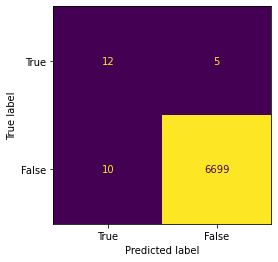

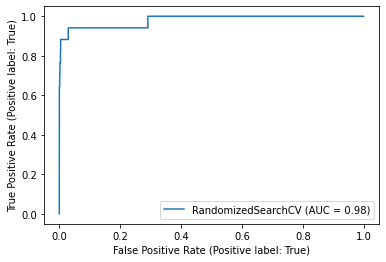

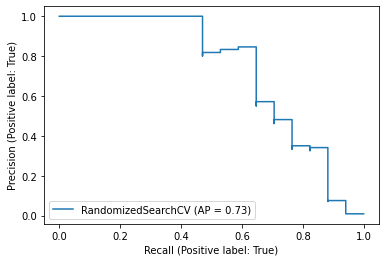

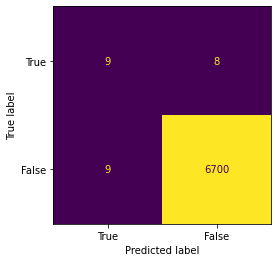

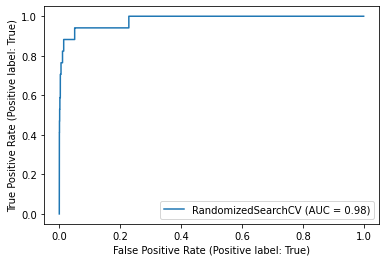

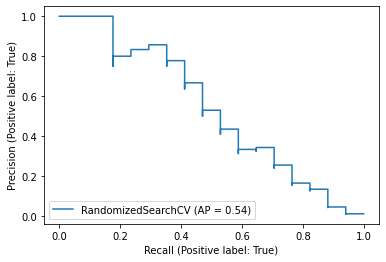

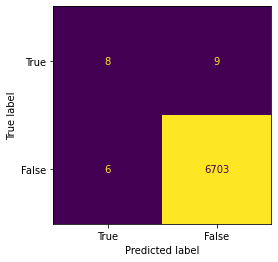

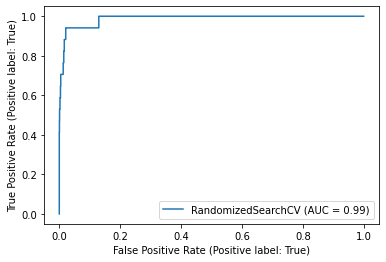

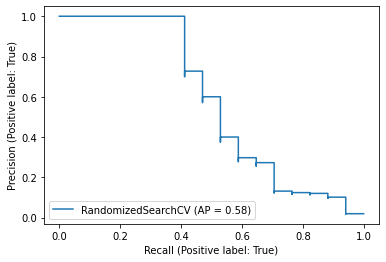

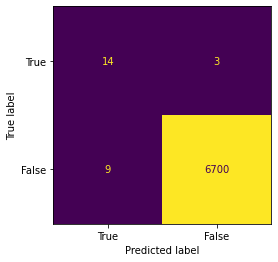

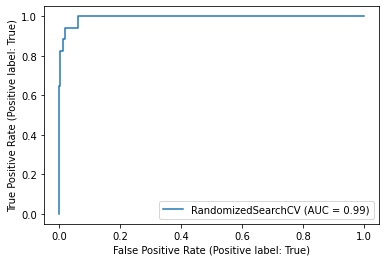

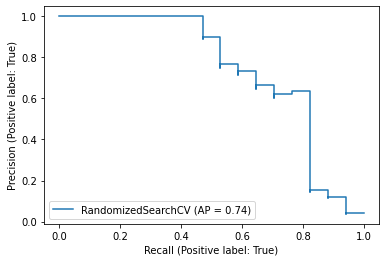

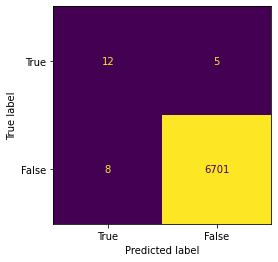

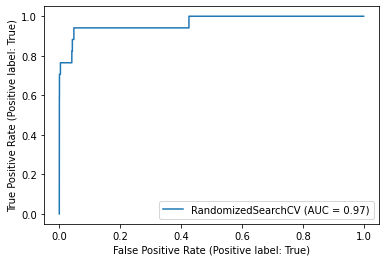

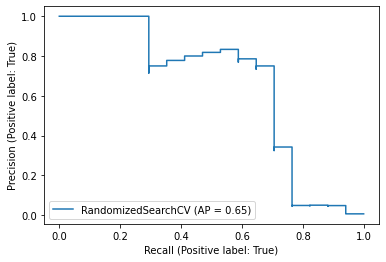

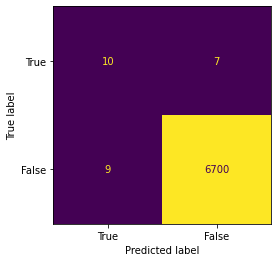

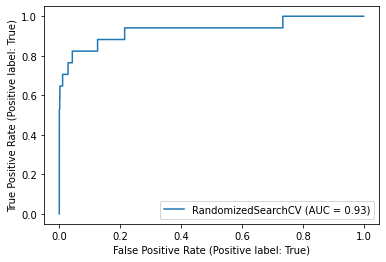

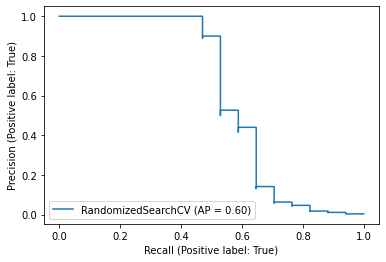

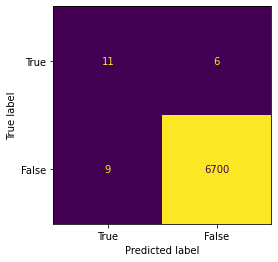

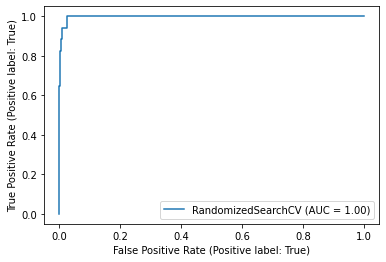

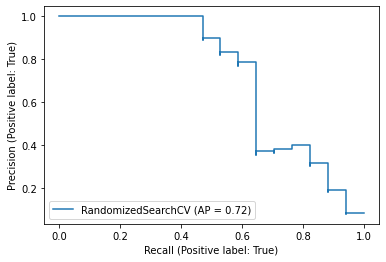

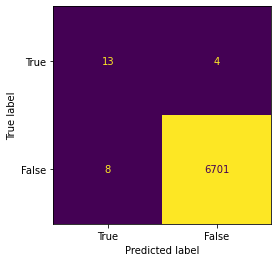

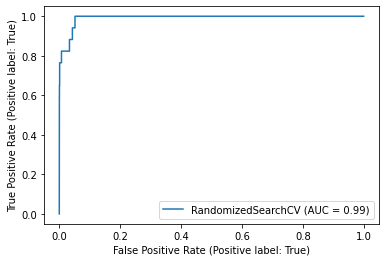

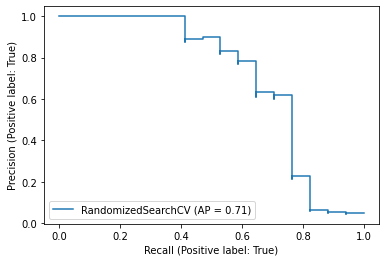

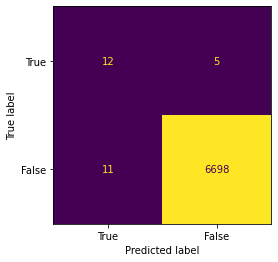

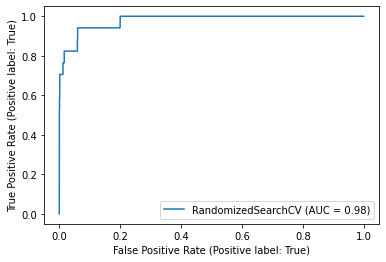

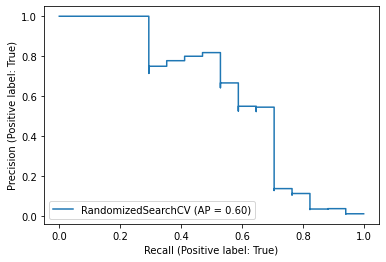

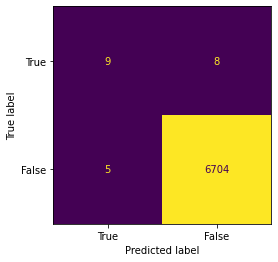

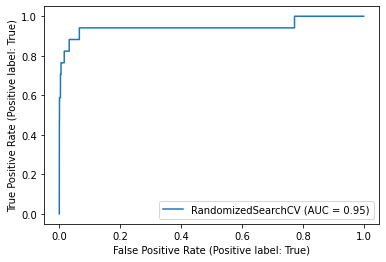

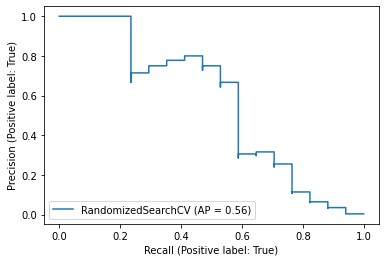

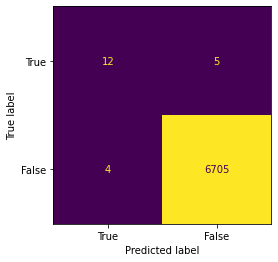

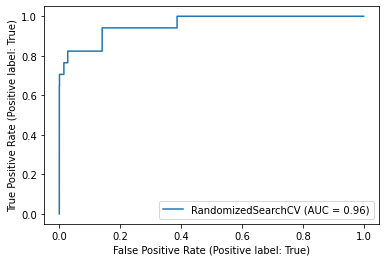

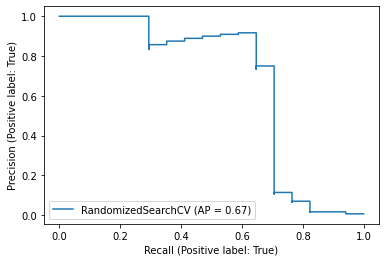

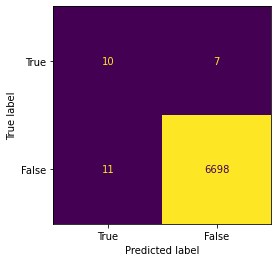

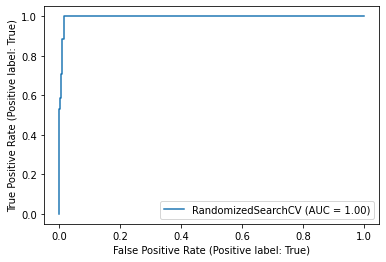

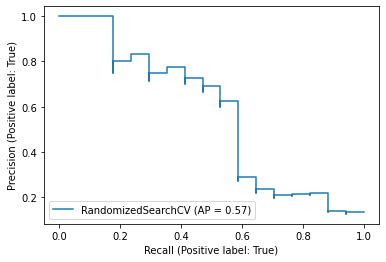

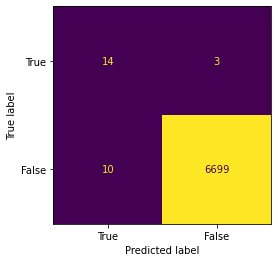

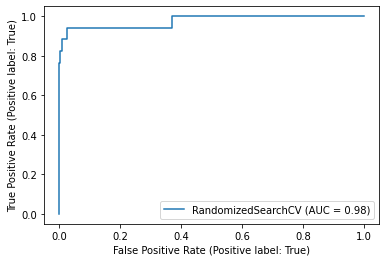

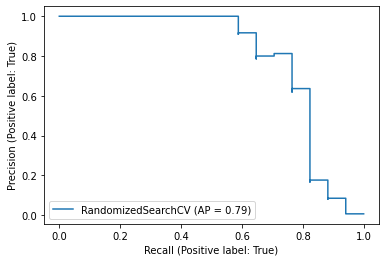

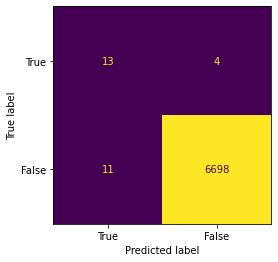

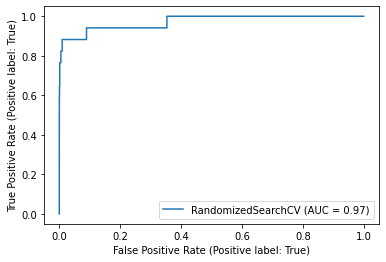

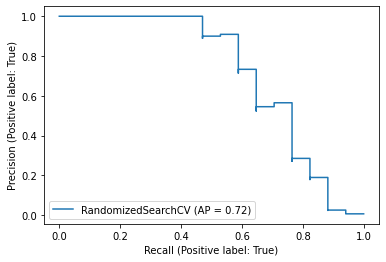

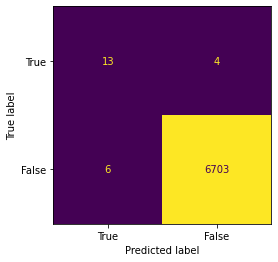

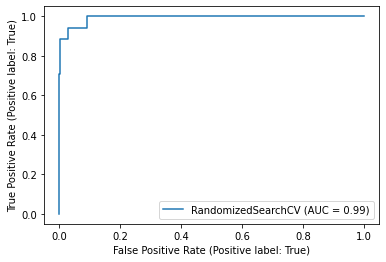

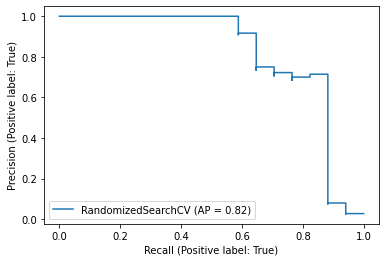

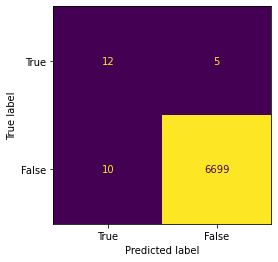

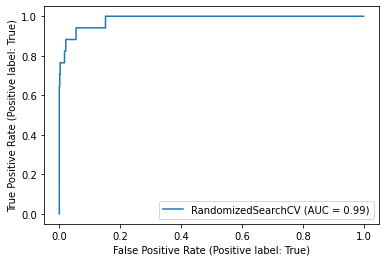

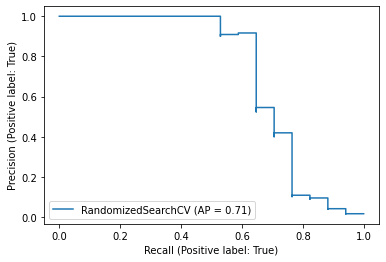

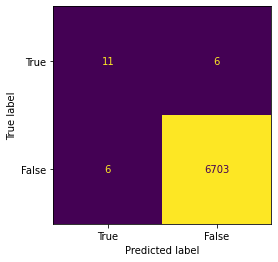

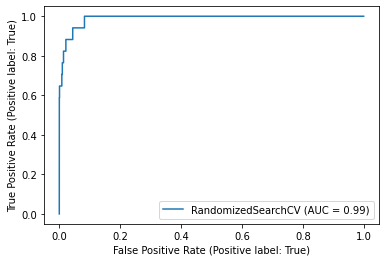

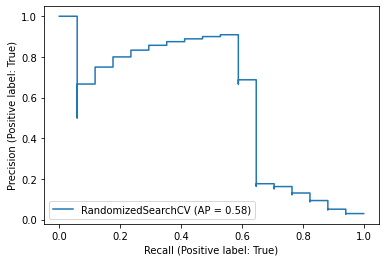

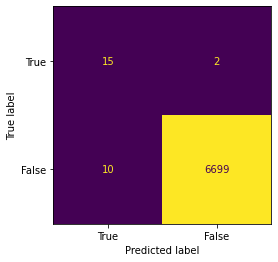

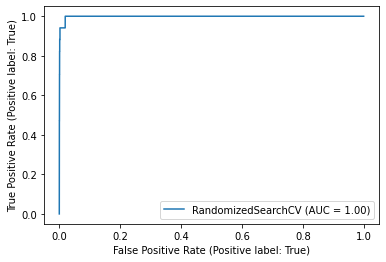

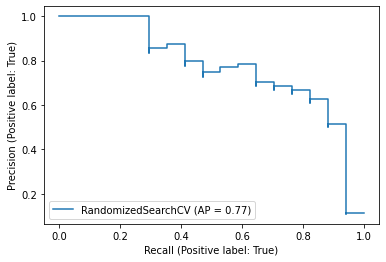

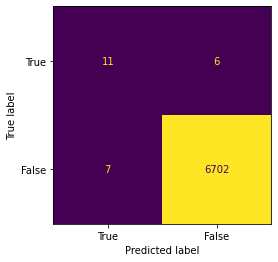

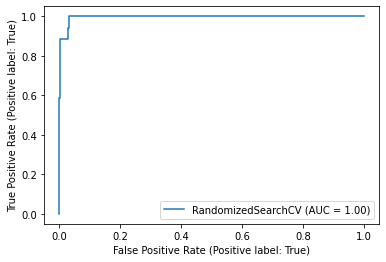

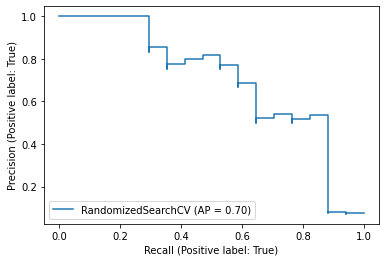

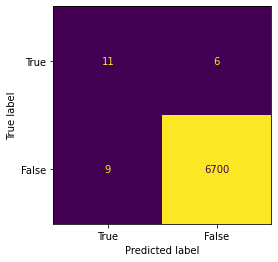

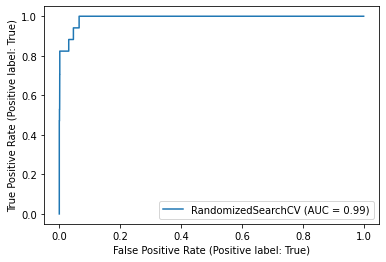

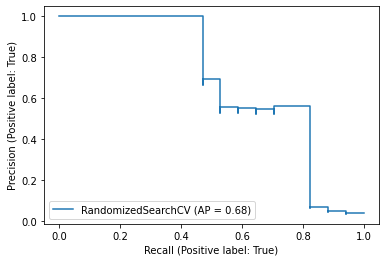

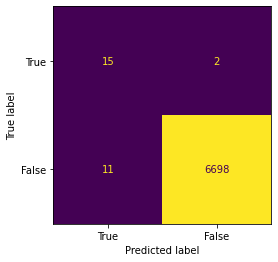

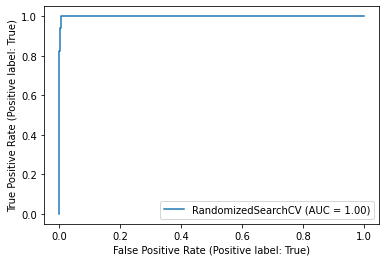

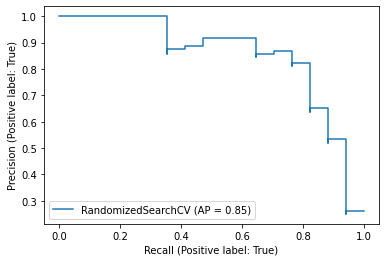

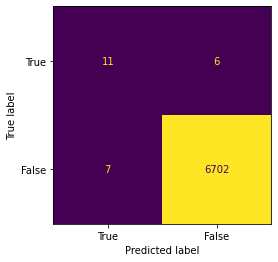

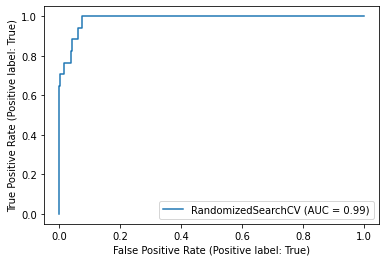

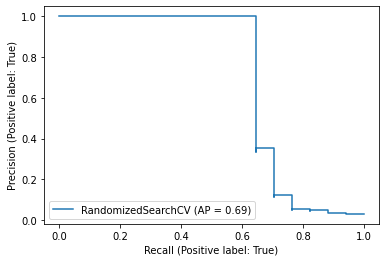

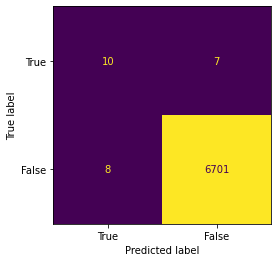

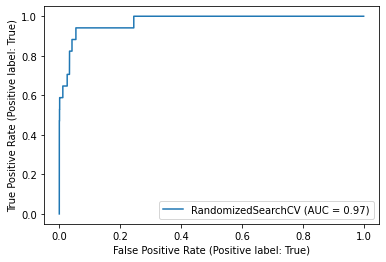

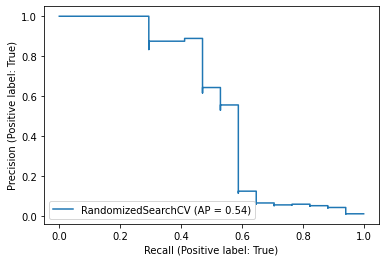

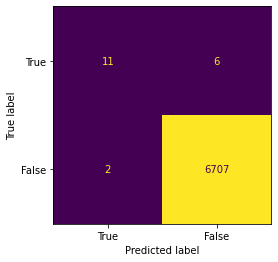

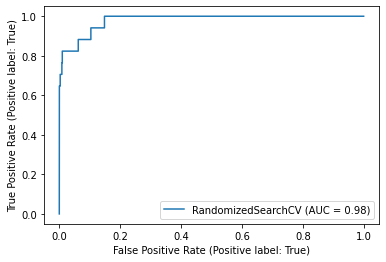

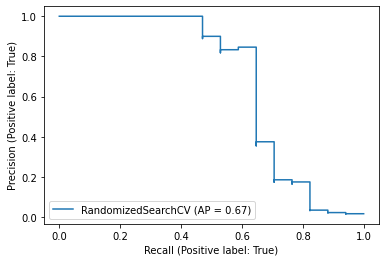

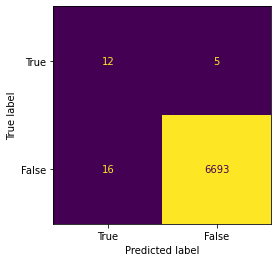

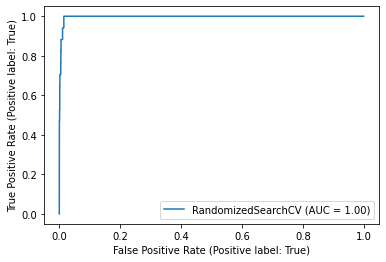

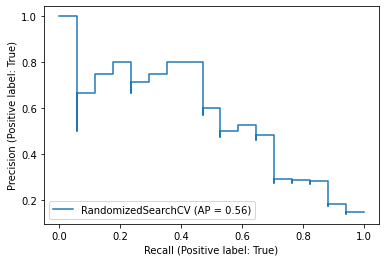

In [11]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb
ftwo_scorer = make_scorer(fbeta_score, beta=2)

for i in range(25):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2, importance_type='gain')]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__num_leaves'] = [11, 16, 21, 26, 31, 36, 41, 46, 51, 56]
    space['classifier__min_data_in_leaf'] =  [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__max_depth'] = [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__learning_rate'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
    space['classifier__max_bin'] = [50, 100, 150, 200, 255, 300, 350, 400, 450, 500]
    spaceEmpty = dict()


    LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedLightGBMModel.best_score_
    test_score = optimizedLightGBMModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)
    
    #feature importance
    importances = optimizedLightGBMModel.best_estimator_._final_estimator.booster_.feature_importance(importance_type='gain')
    for i,v in enumerate(importances):
        print(v)

    #Display the model performance    
    showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)